<a href="https://colab.research.google.com/github/Fanusaez/7506R-2C2022-GRUPO13/blob/sabado-1-10-2022/7506R_TP1_GRUPO13_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Trabajo Practico 1 : Propiedades en Venta

## Grupo 13

### Integrantes:

- Ivan Manuel Pensado
- Axel Tomas Higa
- Edgardo Francisco Saez
- Lautaro Barrionuevo
- Nicolás Carreño


# Importe de librerias


In [1244]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


import scipy.stats as st

from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, MinMaxScaler

import geopandas
from shapely.geometry import Point
import osmnx as ox

# Lectura de archivo


In [1245]:
ds_propiedades = pd.read_csv('properati_argentina_2021.csv')

In [1246]:
ds_propiedades.head()

id  start_date    end_date  created_on    latitud  \
0  XZq2dFGxBiboHY3Bo/tqlw==  2021-09-09  2022-01-27  2021-09-09 -38.957632   
1  8afoK+yMH/rnnlYiktwgNA==  2021-09-09  2021-10-23  2021-09-09 -34.888878   
2  iVaG5rBB47dd1Ya4BMXREA==  2021-09-09  2022-03-09  2021-09-09 -32.488717   
3  QE1QVMWKAHWkd0qT0FtPWA==  2021-09-09  2022-01-27  2021-09-09 -34.900165   
4  tJ5lSk7IysG/71OGhacNZA==  2021-09-09  2022-01-27  2021-09-09 -38.954528   

    longitud    place_l2 place_l3 place_l4 place_l5  place_l6 operation  \
0 -68.105443     Neuquén      NaN      NaN      NaN       NaN     Venta   
1 -56.092368  Montevideo      NaN      NaN      NaN       NaN     Venta   
2 -58.257499  Entre Ríos      NaN      NaN      NaN       NaN     Venta   
3 -54.808453   Maldonado      NaN      NaN      NaN       NaN     Venta   
4 -68.041862     Neuquén      NaN      NaN      NaN       NaN     Venta   

  property_type  property_rooms  property_bedrooms  property_surface_total  \
0          Casa             6.0                NaN                     NaN   
1          Casa             4.0                3.0                   193.0   
2          Casa             NaN                NaN                   110.0   
3          Casa             NaN                3.0                     NaN   
4            PH             3.0                2.0                     NaN   

   property_surface_covered  property_price property_currency  \
0                     206.0             NaN               NaN   
1                     193.0        390000.0               USD   
2                      45.0         47000.0               USD   
3                     180.0        400000.0               USD   
4                      98.0        102000.0               USD   

       property_title  
0      Casa - Capital  
1       Casa - Malvín  
2      Casa - Uruguay  
3    Casa - El Chorro  
4  PH - Villa Farrell

# Análisis Exploratorio y Preprocesamiento de Dato


Se deben filtrar únicamente los anuncios de propiedades de tipo vivienda ( Casa, PH y Departamento ) ubicados en Capital Federal cuyo tipo de operación sea venta y su precio se encuentre en dólares (USD).

In [1247]:
ds_prop_filtrado = ds_propiedades[ds_propiedades.place_l2.str.contains('Capital Federal', case=False, na = False)]
ds_prop_filtrado = ds_prop_filtrado[ds_prop_filtrado.property_type.str.fullmatch('Departamento|Casa|ph', case = False, na = False)]
ds_prop_filtrado = ds_prop_filtrado[ds_prop_filtrado.operation.str.contains('venta', case=False, na =  False)]
ds_prop_filtrado = ds_prop_filtrado[ds_prop_filtrado.property_currency.str.contains('USD', case=False, na =  False)] 

Division Train/Test

In [1248]:
train, test = train_test_split(ds_prop_filtrado,
                                                    test_size=0.2,    #20% al conjunto de test
                                                    random_state=0)
print('# Datos Entrenamiento: {}'.format(len(train)))
print('# Datos Prueba: {}'.format(len(test)))

# Datos Entrenamiento: 75399
# Datos Prueba: 18850


## Exploración inicial


Tipo de variable


In [1249]:
ds_train = train 
ds_test = test

In [1250]:
ds_train.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
place_l2                     object
place_l3                     object
place_l4                     object
place_l5                     object
place_l6                    float64
operation                    object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
property_currency            object
property_title               object
dtype: object

Variables Cuantitativas


In [1251]:
cuantitativos = ["latitud", "longitud", "property_rooms", "property_bedrooms","property_surface_total", "property_surface_covered", "property_price"]
ds_cuantitativo = ds_train.loc[:,cuantitativos]
ds_resumen_cuantitativo = pd.DataFrame()
ds_resumen_cuantitativo["media"] = ds_cuantitativo.mean()
ds_resumen_cuantitativo["mediana"] = ds_cuantitativo.median()
ds_resumen_cuantitativo["q1"] = ds_cuantitativo.quantile([.25]).iloc[0]
ds_resumen_cuantitativo["q3"] = ds_cuantitativo.quantile([.75]).iloc[0]
ds_resumen_cuantitativo["moda"] = ds_cuantitativo.mode().iloc[0]
ds_resumen_cuantitativo

media        mediana            q1  \
latitud                      -34.591533     -34.595789    -34.615975   
longitud                     -58.449751     -58.438956    -58.466432   
property_rooms                 2.824120       3.000000      2.000000   
property_bedrooms              2.015962       2.000000      1.000000   
property_surface_total       112.591274      65.000000     45.000000   
property_surface_covered      88.870856      58.000000     40.000000   
property_price            227201.214446  144000.000000  95000.000000   

                                     q3           moda  
latitud                      -34.577400     -34.541250  
longitud                     -58.408862     -58.472966  
property_rooms                 4.000000       3.000000  
property_bedrooms              3.000000       1.000000  
property_surface_total       105.000000      50.000000  
property_surface_covered      88.000000      40.000000  
property_price            236000.000000  110000.000000

Variables Cualitativas


In [1252]:
cualitativos = ["place_l2", "place_l3", "operation", "property_type", "property_currency", "property_title"]
ds_cualitativo = ds_train.loc[:,cualitativos]

- Mostrar cantidad de valores posibles


In [1253]:
ds_cualitativo.nunique()

place_l2                 1
place_l3                57
operation                1
property_type            3
property_currency        1
property_title       46431
dtype: int64

- Mostrar frecuencias
  - Obviamos las opciones de un solo tipo porque la frecuencia es de 100%


In [1254]:
ds_cualitativo.place_l3.value_counts(normalize=True)* 100

Palermo                 15.351315
Belgrano                 9.561106
Caballito                7.640360
Recoleta                 6.693307
Villa Urquiza            4.981685
Almagro                  4.354312
Nuñez                    3.741592
Villa Crespo             3.381951
Flores                   3.266067
Barrio Norte             3.132867
Balvanera                2.683983
Colegiales               2.075258
Villa Devoto             2.049950
Villa del Parque         1.970030
Saavedra                 1.911422
Puerto Madero            1.607726
San Telmo                1.459873
San Cristobal            1.405261
San Nicolás              1.377289
Barracas                 1.345321
Retiro                   1.313353
Boedo                    1.306693
Floresta                 1.268065
Monserrat                1.200133
Parque Chacabuco         1.165501
Villa Pueyrredón         1.082917
Coghlan                  1.040293
Villa Luro               0.771229
Mataderos                0.764569
Chacarita     

In [1255]:
ds_cualitativo.property_type.value_counts(normalize=True)* 100

Departamento    85.792915
PH               9.868831
Casa             4.338254
Name: property_type, dtype: float64

In [1256]:
ds_cualitativo.property_title.value_counts(normalize=True)* 100

Departamento - Palermo                                                                                               1.588880
Departamento - Recoleta                                                                                              1.388613
Departamento - Belgrano                                                                                              1.141925
Departamento - Caballito                                                                                             0.998687
Departamento - Almagro                                                                                               0.710885
                                                                                                                       ...   
Departamento - Villa Crespo- Palermo Crespo- New-                                                                    0.001326
Excelente depto. Carlos Pellegrini y Posadas, contrafrente con espectacular vistas a jardines y rio; todo externo    0

- Determinar variables irrelevantes en el análisis


Debido a que las caracteristicas cualitativas "place_l2", "operation", "Property_currency" solo poseen un valor posible, es irrelevante para el analisis de datos. 

La caracteristica de "Property_title" al ser una descripcion del vendedor no aporta mucha informacion analitica. 

Los datos que no aportan al analisis, son las fechas, de las columnas "Start_date", "End_date" y "Created_on" debido a que no se especifica que significa dichas fechas e "ID"




In [1257]:
columnas_irrelevantes = ["id", "start_date","end_date", "created_on","place_l2" , "operation", "property_currency", "property_title"]

def eliminar_columnas_irrelevantes(dataset):
    dataset.drop(columns = columnas_irrelevantes, inplace = True)

eliminar_columnas_irrelevantes(ds_train)
eliminar_columnas_irrelevantes(ds_test)
ds_train

latitud   longitud       place_l3 place_l4 place_l5  place_l6  \
280087 -34.601807 -58.469965       Paternal      NaN      NaN       NaN   
256350 -34.580088 -58.424965        Palermo      NaN      NaN       NaN   
135168 -34.551481 -58.452358       Belgrano      NaN      NaN       NaN   
227831 -34.632290 -58.464844         Flores      NaN      NaN       NaN   
409101 -34.549279 -58.463074          Nuñez      NaN      NaN       NaN   
...           ...        ...            ...      ...      ...       ...   
102622 -34.628714 -58.413872          Boedo      NaN      NaN       NaN   
224388 -34.587318 -58.452157      Chacarita      NaN      NaN       NaN   
206610 -34.597385 -58.426269   Villa Crespo      NaN      NaN       NaN   
212425 -34.601109 -58.425161        Almagro      NaN      NaN       NaN   
335036 -34.577672 -58.495749  Villa Urquiza      NaN      NaN       NaN   

       property_type  property_rooms  property_bedrooms  \
280087  Departamento             2.0                1.0   
256350  Departamento             2.0                1.0   
135168  Departamento             1.0                1.0   
227831  Departamento             5.0                3.0   
409101  Departamento             2.0                1.0   
...              ...             ...                ...   
102622  Departamento             3.0                2.0   
224388  Departamento             2.0                1.0   
206610  Departamento             2.0                1.0   
212425  Departamento             2.0                1.0   
335036            PH             2.0                1.0   

        property_surface_total  property_surface_covered  property_price  
280087                    53.0                      49.0         80000.0  
256350                    35.0                      35.0         79900.0  
135168                    25.0                      20.0         69000.0  
227831                    75.0                      75.0        150000.0  
409101                    46.0                      34.0         85000.0  
...                        ...                       ...             ...  
102622                   100.0                      80.0        175000.0  
224388                    61.0                      59.0        122000.0  
206610                    69.0                      56.0        178000.0  
212425                    50.0                      45.0        135000.0  
335036                    53.0                      42.0        100000.0  

[75399 rows x 12 columns]

Duplicados


In [1258]:
ds_train.duplicated

<bound method DataFrame.duplicated of           latitud   longitud       place_l3 place_l4 place_l5  place_l6  \
280087 -34.601807 -58.469965       Paternal      NaN      NaN       NaN   
256350 -34.580088 -58.424965        Palermo      NaN      NaN       NaN   
135168 -34.551481 -58.452358       Belgrano      NaN      NaN       NaN   
227831 -34.632290 -58.464844         Flores      NaN      NaN       NaN   
409101 -34.549279 -58.463074          Nuñez      NaN      NaN       NaN   
...           ...        ...            ...      ...      ...       ...   
102622 -34.628714 -58.413872          Boedo      NaN      NaN       NaN   
224388 -34.587318 -58.452157      Chacarita      NaN      NaN       NaN   
206610 -34.597385 -58.426269   Villa Crespo      NaN      NaN       NaN   
212425 -34.601109 -58.425161        Almagro      NaN      NaN       NaN   
335036 -34.577672 -58.495749  Villa Urquiza      NaN      NaN       NaN   

       property_type  property_rooms  property_bedrooms  \
28

### Realizar un análisis gráfico de las distribuciones de las variables


#### Barrio

Cantidad de barrios

In [1259]:
cant_barrios = ds_train["place_l3"].unique().size
print("La cantidad de Barrios es: " + str(cant_barrios))

La cantidad de Barrios es: 58


Cantidadad de propiedades por barrios

In [1260]:
ds_train["place_l3"].value_counts()

Palermo                 11525
Belgrano                 7178
Caballito                5736
Recoleta                 5025
Villa Urquiza            3740
Almagro                  3269
Nuñez                    2809
Villa Crespo             2539
Flores                   2452
Barrio Norte             2352
Balvanera                2015
Colegiales               1558
Villa Devoto             1539
Villa del Parque         1479
Saavedra                 1435
Puerto Madero            1207
San Telmo                1096
San Cristobal            1055
San Nicolás              1034
Barracas                 1010
Retiro                    986
Boedo                     981
Floresta                  952
Monserrat                 901
Parque Chacabuco          875
Villa Pueyrredón          813
Coghlan                   781
Villa Luro                579
Mataderos                 574
Chacarita                 555
Liniers                   534
Villa Ortuzar             529
Parque Patricios          514
Villa Luga

Distribucion

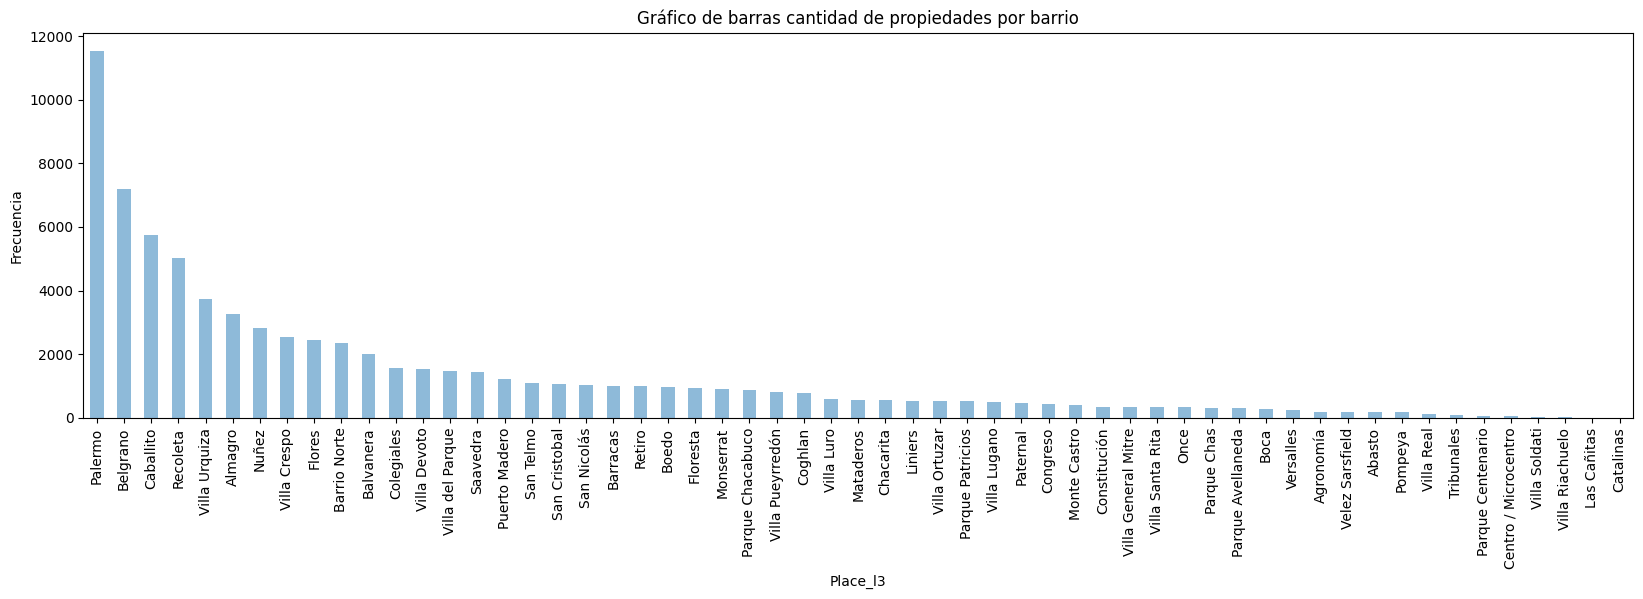

In [1261]:
grf_ds=ds_train["place_l3"].value_counts().plot.bar(alpha=0.5 , title="Gráfico de barras cantidad de propiedades por barrio" , xlabel="Place_l3" , ylabel="Frecuencia", figsize=(20,5))

Precio promedio de propiedad por barrio

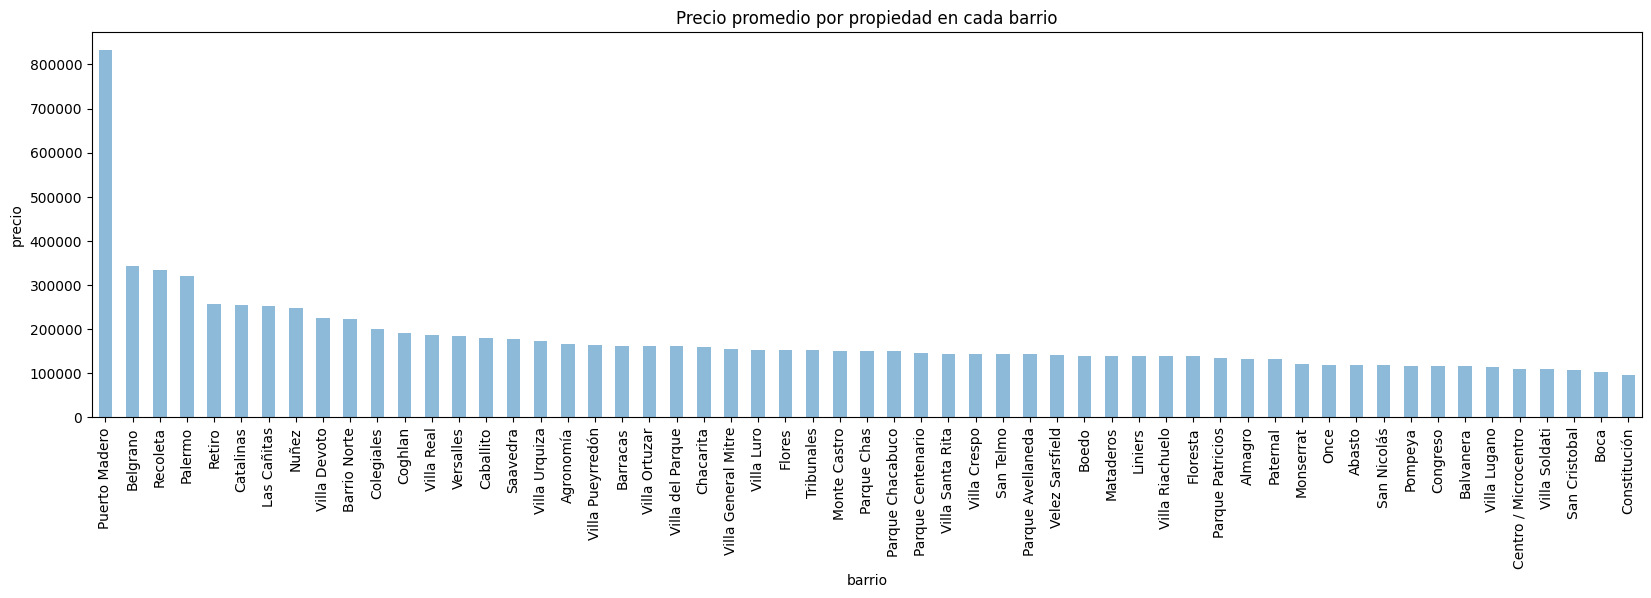

In [1262]:
ds_precio_prom = ds_train.groupby(["place_l3"])["property_price"].mean().sort_values(ascending=False)
grf_ds=ds_precio_prom.plot.bar(alpha=0.5 , title="Precio promedio por propiedad en cada barrio" , xlabel="barrio" , ylabel="precio", figsize=(20,5))

#### Rooms

Cantidad de propiedades con 'n' habitaciones

In [1263]:
ds_train["property_rooms"].value_counts()

3.0     21470
2.0     21120
4.0     13128
1.0     12053
5.0      4135
6.0      1464
7.0       596
8.0       283
9.0       136
10.0       83
11.0       26
12.0       25
14.0       15
15.0       10
13.0        6
16.0        3
20.0        3
18.0        2
17.0        2
19.0        2
30.0        1
35.0        1
24.0        1
28.0        1
32.0        1
36.0        1
Name: property_rooms, dtype: int64

Box plot

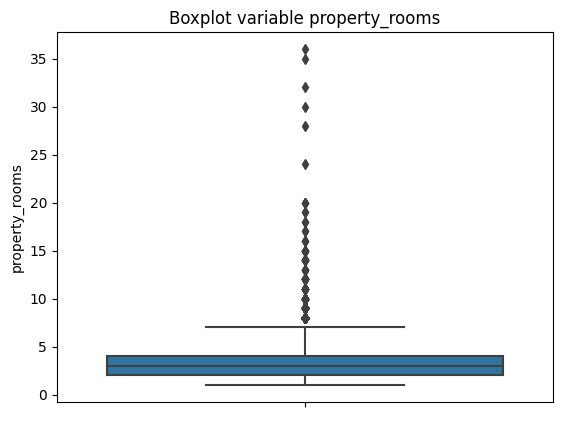

In [1264]:
grf=sns.boxplot(y="property_rooms", data=ds_train).set(title="Boxplot variable property_rooms",xlabel=" ",ylabel="property_rooms")

#### Bedrooms

Cantidad de propiedades con 'n' dormitorios

In [1265]:
ds_train["property_bedrooms"].value_counts()

 1.0     25513
 2.0     22047
 3.0     14112
 4.0      3821
 5.0       742
 6.0       194
 7.0        84
 8.0        48
 10.0       22
 9.0        21
 12.0       15
 16.0        6
 11.0        6
 14.0        5
 32.0        3
 13.0        3
 18.0        3
 20.0        3
 17.0        3
 15.0        3
 22.0        2
 70.0        1
 30.0        1
-1.0         1
Name: property_bedrooms, dtype: int64

Boxplot

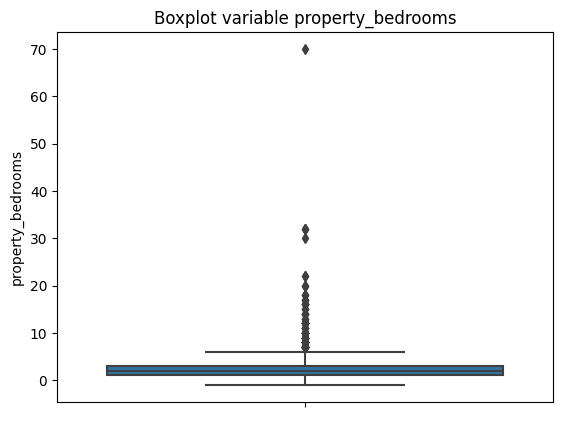

In [1266]:
grf=sns.boxplot(y="property_bedrooms", data=ds_train).set(title="Boxplot variable property_bedrooms",xlabel=" ",ylabel="property_bedrooms")

#### Surface Total & Covered

Boxplot surface_total

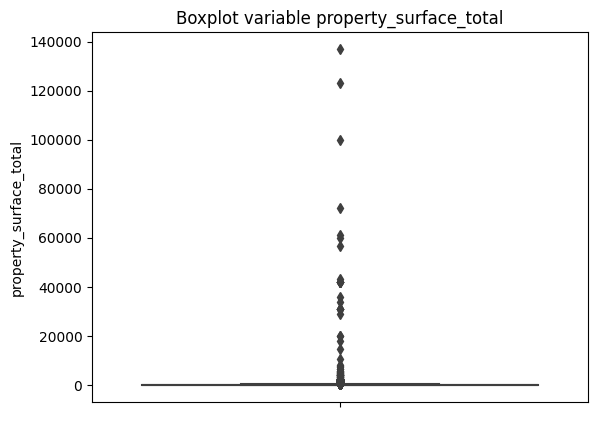

In [1267]:
grf=sns.boxplot(y="property_surface_total", data=ds_train).set(title="Boxplot variable property_surface_total",xlabel=" ",ylabel="property_surface_total")

Boxplot suface_covered

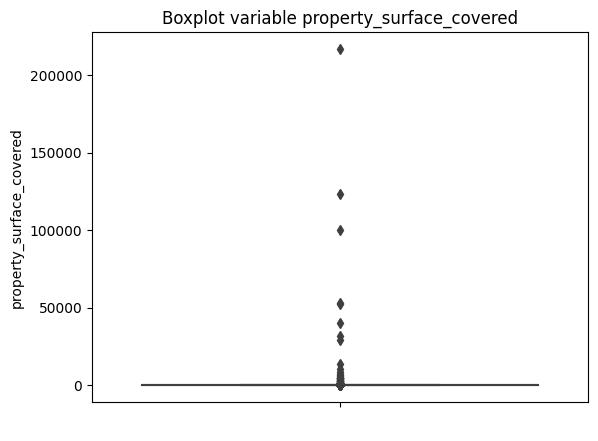

In [1268]:
grf=sns.boxplot(y="property_surface_covered", data=ds_train).set(title="Boxplot variable property_surface_covered",xlabel=" ",ylabel="property_surface_covered")

Valor maximo, minimo y promedio

In [1269]:
max = ds_train["property_surface_total"].max()
min = ds_train["property_surface_total"].min()
mean = ds_train["property_surface_total"].mean().round()

print("Property_surface_total")
print("El valor maximo es: " + str(max))
print("El valor minimo es: " + str(min))
print("El valor promedio es: " + str(mean) + "\n")

max = ds_train["property_surface_covered"].max()
min = ds_train["property_surface_covered"].min()
mean = ds_train["property_surface_covered"].mean().round()

print("Property_surface_covered")
print("El valor maximo es: " + str(max))
print("El valor minimo es: " + str(min))
print("El valor promedio es: " + str(mean))



Property_surface_total
El valor maximo es: 137000.0
El valor minimo es: 10.0
El valor promedio es: 113.0

Property_surface_covered
El valor maximo es: 217000.0
El valor minimo es: 1.0
El valor promedio es: 89.0


#### Price

Boxplot

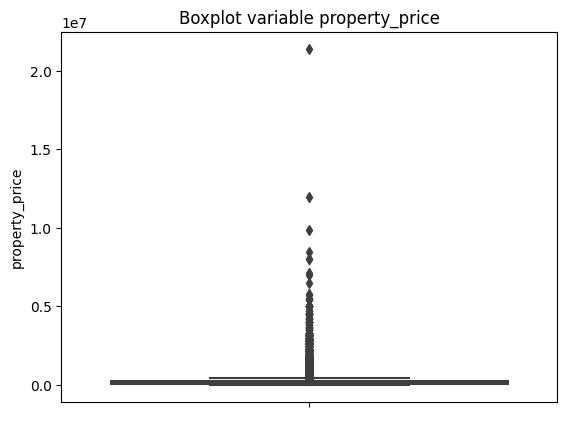

In [1270]:
grf=sns.boxplot(y="property_price", data=ds_train).set(title="Boxplot variable property_price",xlabel=" ",ylabel="property_price")

Precio maximo y minimo y promedio

In [1271]:
max = ds_train["property_price"].max()
min = ds_train["property_price"].min()
mean = ds_train["property_price"].mean().round()

print("El precio maximo es: " + str(max))
print("El precio minimo es: " + str(min))
print("El precio promedio es: " + str(mean))


El precio maximo es: 21400000.0
El precio minimo es: 5000.0
El precio promedio es: 227201.0


### Correlaciones existentes entre las variables


- Analizar las correlaciones existentes entre las variables.


In [1272]:
ds_train.corr()

latitud  longitud  place_l6  property_rooms  \
latitud                   1.000000 -0.230156       NaN        0.003493   
longitud                 -0.230156  1.000000       NaN       -0.007947   
place_l6                       NaN       NaN       NaN             NaN   
property_rooms            0.003493 -0.007947       NaN        1.000000   
property_bedrooms         0.000608 -0.008389       NaN        0.871541   
property_surface_total    0.024694 -0.014160       NaN        0.061457   
property_surface_covered  0.001964 -0.000942       NaN        0.074062   
property_price            0.016166  0.023086       NaN        0.483192   

                          property_bedrooms  property_surface_total  \
latitud                            0.000608                0.024694   
longitud                          -0.008389               -0.014160   
place_l6                                NaN                     NaN   
property_rooms                     0.871541                0.061457   
property_bedrooms                  1.000000                0.062421   
property_surface_total             0.062421                1.000000   
property_surface_covered           0.067214                0.660050   
property_price                     0.416916                0.081746   

                          property_surface_covered  property_price  
latitud                                   0.001964        0.016166  
longitud                                 -0.000942        0.023086  
place_l6                                       NaN             NaN  
property_rooms                            0.074062        0.483192  
property_bedrooms                         0.067214        0.416916  
property_surface_total                    0.660050        0.081746  
property_surface_covered                  1.000000        0.053285  
property_price                            0.053285        1.000000

- Notar alta correlacion entre "property_rooms" y "property_bedrooms", lo cual tiene mucho sentido ya que un departamento de 3 ambientes tiene 2 habitaciones, uno de 4 ambientes tiene 3 habitacioenes etc 
- Tambien podemos encontrar una correlcion moderada entre "property_surface_total" y "property_surface_covered" lo cual tambien se asemeja a la relaidad. Lo mismo con "property_price" y "property_rooms"

#### Propety_bedrooms y Property_rooms

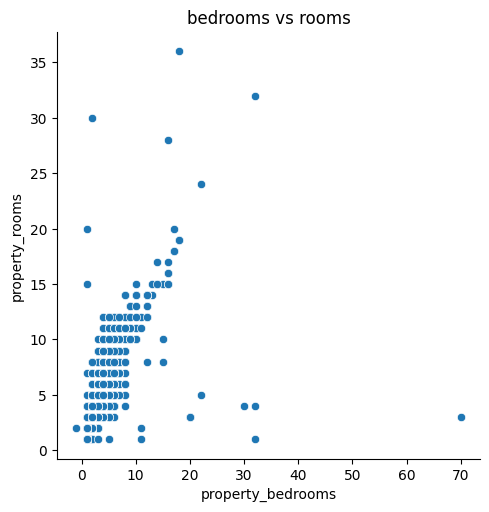

In [1273]:
graf_relplot=sns.relplot(data=ds_train, x="property_bedrooms", y="property_rooms").set(title="bedrooms vs rooms",xlabel='property_bedrooms',ylabel='property_rooms')

#### Surface_total y Surface_covered

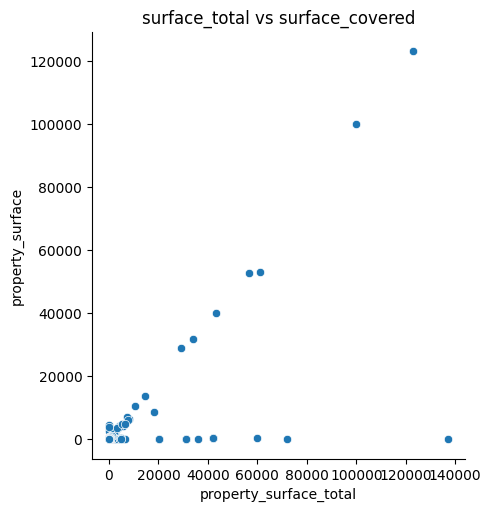

In [1274]:
graf_relplot=sns.relplot(data=ds_train, x="property_surface_total", y="property_surface_covered").set(title="surface_total vs surface_covered",xlabel='property_surface_total',ylabel='property_surface')

#### Price y Rooms

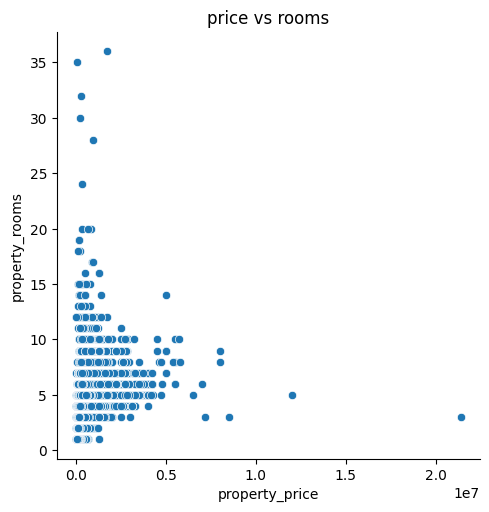

In [1275]:
graf_relplot=sns.relplot(data=ds_train, x="property_price", y="property_rooms").set(title="price vs rooms",xlabel='property_price',ylabel='property_rooms')

Precio promedio de propiedad por Barrio


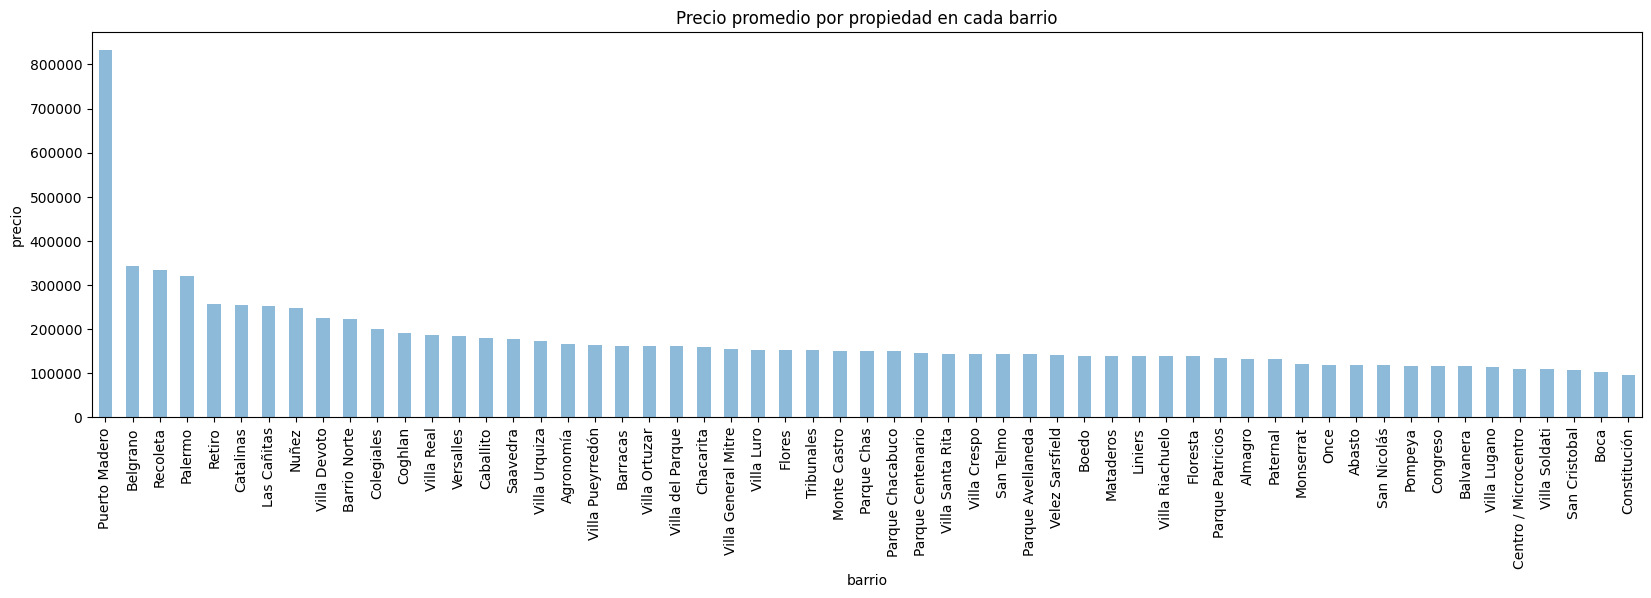

In [1276]:
ds_precio_prom = ds_train.groupby(["place_l3"])["property_price"].mean().sort_values(ascending=False)
grf_ds=ds_precio_prom.plot.bar(alpha=0.5 , title="Precio promedio por propiedad en cada barrio" , xlabel="barrio" , ylabel="precio", figsize=(20,5))

### Conslusiones exploracion inicial

El analisis al que podemos llegar con la exoloracion inicial realizada es:

- Tenemos mucha mayor cantidad de propiedades de tipo "Departamento", que de tipo "Casa" o "PH"
- Mucha cantidad de propiedades en zonas como Palermo, Belgrano, Caballito y Recoleta
- La zona con el promedio de precios mas alto es Puerto Madero 
- Encontramos columnas en el dataset que debido a su falta de utilidad en el trabajo o su alto porcentaje de valores faltantes, decidimos sacarlos del dataset

## Datos faltantes


### Análisis de datos faltantes

Porcentaje de datos faltantes por columna

In [1277]:
filas_totales=ds_train.shape[0]
print(ds_train.isna().sum()/filas_totales*100)

latitud                       3.986790
longitud                      3.986790
place_l3                      0.429714
place_l4                     96.045040
place_l5                    100.000000
place_l6                    100.000000
property_type                 0.000000
property_rooms                1.102137
property_bedrooms            11.591666
property_surface_total        5.099537
property_surface_covered      3.587581
property_price                0.000000
dtype: float64


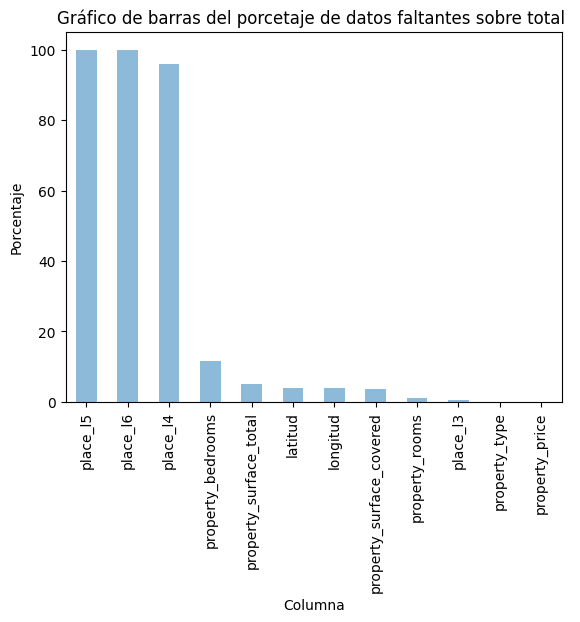

In [1278]:
ds_porcentaje = ds_train.isna().sum()/filas_totales*100
ds_porcentaje = ds_porcentaje.sort_values(ascending=False)
grf_ds = ds_porcentaje.plot.bar(alpha=0.5 , title="Gráfico de barras del porcetaje de datos faltantes sobre total " , xlabel="Columna" , ylabel="Porcentaje")

Tomando en cuenta estos resultados, decidimos eliminar las columnas l4 , l5 y l6 debido a que el porcentaje de datos faltantes es total o casi total. En el caso de l5 y l6 son de 100 por ciento por lo cual no se podria completar y en el caso de l4 son las subdivisiones barriales de los cuales muchos no poseen.


In [1279]:

columnas_a_elimianar = ["place_l4","place_l5","place_l6"]
def eliminar_columnas_nans(dataset):
    dataset.drop(columns = columnas_a_elimianar, inplace = True)
    
eliminar_columnas_nans(ds_train)
eliminar_columnas_nans(ds_test)

In [1280]:
ds_train.head()

latitud   longitud  place_l3 property_type  property_rooms  \
280087 -34.601807 -58.469965  Paternal  Departamento             2.0   
256350 -34.580088 -58.424965   Palermo  Departamento             2.0   
135168 -34.551481 -58.452358  Belgrano  Departamento             1.0   
227831 -34.632290 -58.464844    Flores  Departamento             5.0   
409101 -34.549279 -58.463074     Nuñez  Departamento             2.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
280087                1.0                    53.0                      49.0   
256350                1.0                    35.0                      35.0   
135168                1.0                    25.0                      20.0   
227831                3.0                    75.0                      75.0   
409101                1.0                    46.0                      34.0   

        property_price  
280087         80000.0  
256350         79900.0  
135168         69000.0  
227831        150000.0  
409101         85000.0

#### Latitud y Longitud

Grafico de cantidad de datos faltantes respecto al total

In [1281]:
lat_long = ds_train[["latitud", "longitud"]].isna()

lat_long.loc[lat_long.loc[:,"latitud"]==True,"latitud"]="nans"
lat_long.loc[lat_long.loc[:,"latitud"]==False,"latitud"]="no_nans"

lat_long.loc[lat_long.loc[:,"longitud"]==True,"longitud"]="nans"
lat_long.loc[lat_long.loc[:,"longitud"]==False,"longitud"]="no_nans"

lat_long.head()

latitud longitud
280087  no_nans  no_nans
256350  no_nans  no_nans
135168  no_nans  no_nans
227831  no_nans  no_nans
409101  no_nans  no_nans

Grafico Latitud

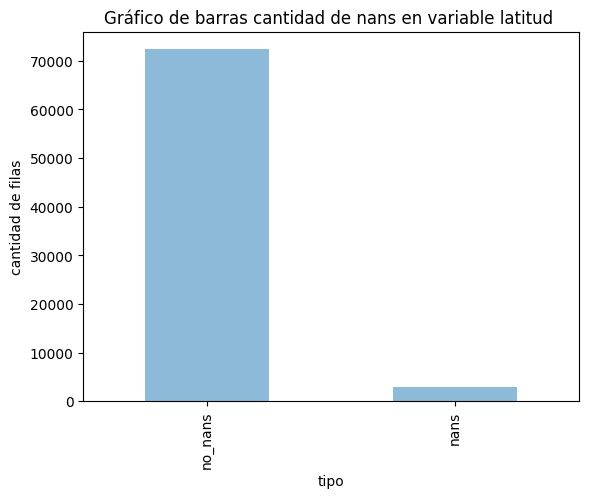

In [1282]:
grf_ds=lat_long["latitud"].value_counts().plot.bar(alpha=0.5 , title="Gráfico de barras cantidad de nans en variable latitud " , xlabel="tipo" , ylabel="cantidad de filas")

In [1283]:
cant_no_nans = lat_long["latitud"].value_counts().to_list()[0]
cant_nans = lat_long["latitud"].value_counts().to_list()[1]

print("Cantidad total del dataset: " + str(cant_no_nans + cant_nans))
print("Cantidad total de nans: " + str(cant_nans))

Cantidad total del dataset: 75399
Cantidad total de nans: 3006


Grafico longitud

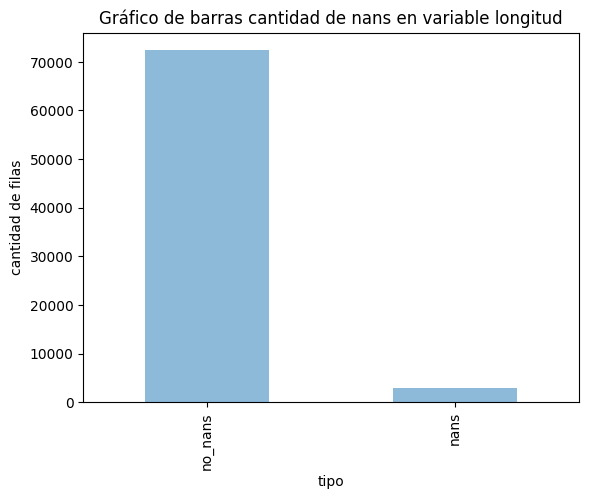

In [1284]:
grf_ds=lat_long["longitud"].value_counts().plot.bar(alpha=0.5 , title="Gráfico de barras cantidad de nans en variable longitud" , xlabel="tipo" , ylabel="cantidad de filas")

In [1285]:
cant_no_nans = lat_long["longitud"].value_counts().to_list()[0]
cant_nans = lat_long["longitud"].value_counts().to_list()[1]

print("Cantidad total del dataset: " + str(cant_no_nans + cant_nans))
print("Cantidad total de nans: " + str(cant_nans))

Cantidad total del dataset: 75399
Cantidad total de nans: 3006


#### Barrio (place_l3)

In [1286]:
barrio = ds_train[["place_l3"]].isna()

barrio.loc[barrio.loc[:,"place_l3"]==True,"place_l3"]= "nans"
barrio.loc[barrio.loc[:,"place_l3"]==False,"place_l3"]= "no_nans"

barrio.head()

place_l3
280087  no_nans
256350  no_nans
135168  no_nans
227831  no_nans
409101  no_nans

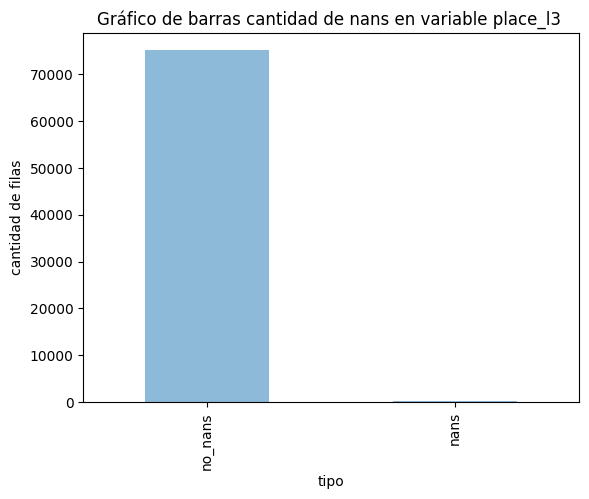

In [1287]:
grf_ds=barrio["place_l3"].value_counts().plot.bar(alpha=0.5 , title="Gráfico de barras cantidad de nans en variable place_l3 " , xlabel="tipo" , ylabel="cantidad de filas")

In [1288]:
cant_no_nans = barrio["place_l3"].value_counts().to_list()[0]
cant_nans = barrio["place_l3"].value_counts().to_list()[1]

print("Cantidad total del dataset: " + str(cant_no_nans + cant_nans))
print("Cantidad total de nans: " + str(cant_nans))

Cantidad total del dataset: 75399
Cantidad total de nans: 324


#### Rooms & bedrooms

In [1289]:
rooms_bedrooms = ds_train[["property_rooms", "property_bedrooms"]].isna()

rooms_bedrooms.loc[rooms_bedrooms.loc[:,"property_rooms"]==True,"property_rooms"]="nans"
rooms_bedrooms.loc[rooms_bedrooms.loc[:,"property_rooms"]==False,"property_rooms"]="no_nans"

rooms_bedrooms.loc[rooms_bedrooms.loc[:,"property_bedrooms"]==True,"property_bedrooms"]="nans"
rooms_bedrooms.loc[rooms_bedrooms.loc[:,"property_bedrooms"]==False,"property_bedrooms"]="no_nans"

rooms_bedrooms.head()

property_rooms property_bedrooms
280087        no_nans           no_nans
256350        no_nans           no_nans
135168        no_nans           no_nans
227831        no_nans           no_nans
409101        no_nans           no_nans

Variable property_rooms

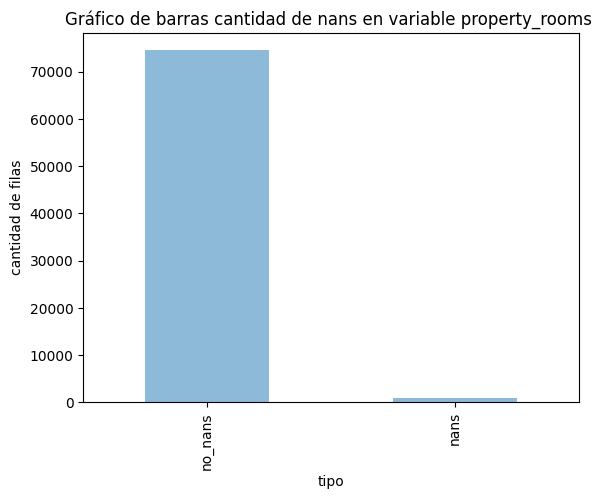

In [1290]:
grf_ds=rooms_bedrooms["property_rooms"].value_counts().plot.bar(alpha=0.5 , title="Gráfico de barras cantidad de nans en variable property_rooms " , xlabel="tipo" , ylabel="cantidad de filas")

In [1291]:
cant_no_nans = rooms_bedrooms["property_rooms"].value_counts().to_list()[0]
cant_nans = rooms_bedrooms["property_rooms"].value_counts().to_list()[1]

print("Cantidad total del dataset: " + str(cant_no_nans + cant_nans))
print("Cantidad total de nans: " + str(cant_nans))

Cantidad total del dataset: 75399
Cantidad total de nans: 831


Variable property_bedrooms

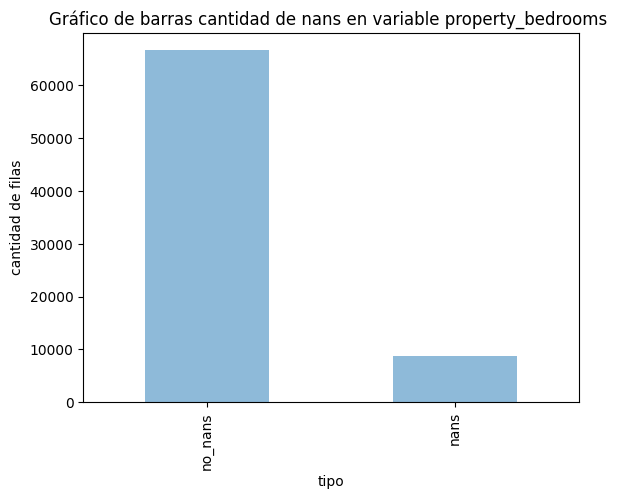

In [1292]:
grf_ds=rooms_bedrooms["property_bedrooms"].value_counts().plot.bar(alpha=0.5 , title="Gráfico de barras cantidad de nans en variable property_bedrooms " , xlabel="tipo" , ylabel="cantidad de filas")

In [1293]:
cant_no_nans = rooms_bedrooms["property_bedrooms"].value_counts().to_list()[0]
cant_nans = rooms_bedrooms["property_bedrooms"].value_counts().to_list()[1]

print("Cantidad total del dataset: " + str(cant_no_nans + cant_nans))
print("Cantidad total de nans: " + str(cant_nans))

Cantidad total del dataset: 75399
Cantidad total de nans: 8740


#### Surface Total & Covered

In [1294]:
total_covered = ds_train[["property_surface_total", "property_surface_covered"]].isna()

total_covered.loc[total_covered.loc[:,"property_surface_total"]==True,"property_surface_total"]="nans"
total_covered.loc[total_covered.loc[:,"property_surface_total"]==False,"property_surface_total"]="no_nans"

total_covered.loc[total_covered.loc[:,"property_surface_covered"]==True,"property_surface_covered"]="nans"
total_covered.loc[total_covered.loc[:,"property_surface_covered"]==False,"property_surface_covered"]="no_nans"

total_covered.head()

property_surface_total property_surface_covered
280087                no_nans                  no_nans
256350                no_nans                  no_nans
135168                no_nans                  no_nans
227831                no_nans                  no_nans
409101                no_nans                  no_nans

Variable property_surface_total

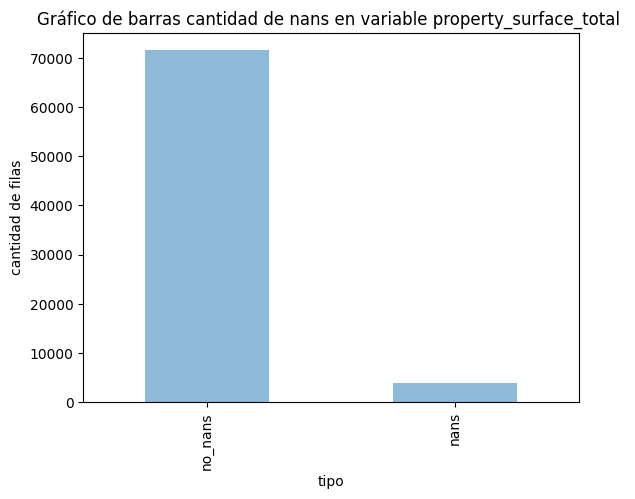

In [1295]:
grf_ds=total_covered["property_surface_total"].value_counts().plot.bar(alpha=0.5 , title="Gráfico de barras cantidad de nans en variable property_surface_total " , xlabel="tipo" , ylabel="cantidad de filas")

In [1296]:
cant_no_nans = total_covered["property_surface_total"].value_counts().to_list()[0]
cant_nans = total_covered["property_surface_total"].value_counts().to_list()[1]

print("Cantidad total del dataset: " + str(cant_no_nans + cant_nans))
print("Cantidad total de nans: " + str(cant_nans))

Cantidad total del dataset: 75399
Cantidad total de nans: 3845


Variable property_surface_covered

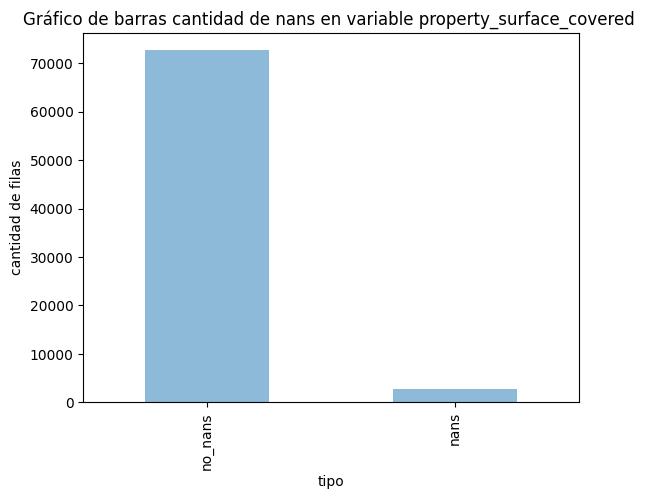

In [1297]:
grf_ds=total_covered["property_surface_covered"].value_counts().plot.bar(alpha=0.5 , title="Gráfico de barras cantidad de nans en variable property_surface_covered " , xlabel="tipo" , ylabel="cantidad de filas")

In [1298]:
cant_no_nans = total_covered["property_surface_covered"].value_counts().to_list()[0]
cant_nans = total_covered["property_surface_covered"].value_counts().to_list()[1]

print("Cantidad total del dataset: " + str(cant_no_nans + cant_nans))
print("Cantidad total de nans: " + str(cant_nans))

Cantidad total del dataset: 75399
Cantidad total de nans: 2705


#### Precio

In [1299]:
precio = ds_train[["property_price"]].isna()

precio.loc[precio.loc[:,"property_price"]==True,"property_price"]= "nans"
precio.loc[precio.loc[:,"property_price"]==False,"property_price"]= "no_nans"

precio.head()

property_price
280087        no_nans
256350        no_nans
135168        no_nans
227831        no_nans
409101        no_nans

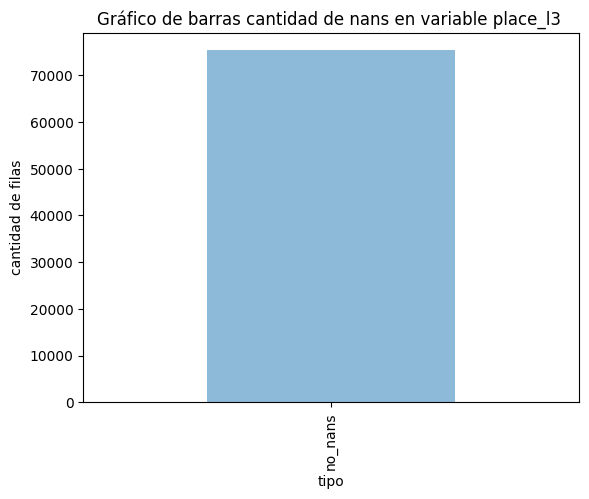

In [1300]:
grf_ds=precio["property_price"].value_counts().plot.bar(alpha=0.5 , title="Gráfico de barras cantidad de nans en variable place_l3 " , xlabel="tipo" , ylabel="cantidad de filas")

Esta variable no posee valores nulos, al igual que "property_type"

### Datos faltantes a nivel fila

Cantidad de filas que poseen datos faltantes

In [1301]:
filas_cantidad_nan = pd.DataFrame(ds_train).isna().sum(axis=1).to_frame("cantidad")
cantidad = len(filas_cantidad_nan[filas_cantidad_nan["cantidad"] > 0])
print(f"Hay {cantidad} lineas que poseen uno o mas valores faltantes")

Hay 17072 lineas que poseen uno o mas valores faltantes


Grafico de barras de cantidad de filas con diferente cantidad de valores nulos

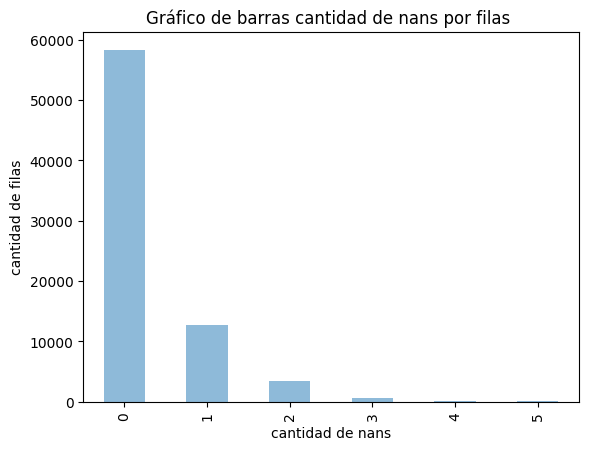

In [1302]:
grf_ds=filas_cantidad_nan['cantidad'].value_counts().plot.bar(alpha=0.5 , title="Gráfico de barras cantidad de nans por filas " , xlabel="cantidad de nans" , ylabel="cantidad de filas")

In [1303]:
cant_nans_fila = filas_cantidad_nan['cantidad'].value_counts()
cero = cant_nans_fila[0]
uno = cant_nans_fila[1]
dos =  cant_nans_fila[2]
tres =  cant_nans_fila[3]
cuatro = cant_nans_fila[4]
cinco = cant_nans_fila[5]

### Estartegias para rellenar valores faltantes

#### Cold deck para rellenar barrios

Dado que poseemos la latitud y longitud de casi todas las propiedades, vamos a utilizar imputacion Cold Deck, para rellenar los datos faltantes de la columna "place_l3"

Primero procedemos imputando los cualitativos, que en este caso solo es el place_l3.
Utilizando un archivo csv proporcionado por el gobierno de la Ciudad Autonoma de Buenos Aires, el cual nos proporcionorá el nombre de la localidad usando latitud y longitud, mediante la utilizacion de Polygon.
https://data.buenosaires.gob.ar/dataset/barrios


In [1304]:
ds_barrios = pd.read_csv('barrios.csv', header=0,sep=';')

from shapely.geometry import MultiPolygon, Polygon, Point
from shapely import wkt
ds_barrios.WKT = ds_barrios.WKT

def rellenar_barrios(dataset):
    for index, registro_prop in dataset.iterrows():
        if  type(registro_prop["place_l3"]) is str:
            continue
        for index_, registro_barrio in ds_barrios.iterrows():
            if wkt.loads(registro_barrio.WKT).covers(Point(registro_prop.longitud,registro_prop.latitud)):
                barrio_aux = registro_barrio['BARRIO']
                dataset.loc[index, 'place_l3'] = barrio_aux

rellenar_barrios(ds_train)
rellenar_barrios(ds_test)

Me fijo si quedo algun place_l3 incompleto.


In [1305]:
ds_train["place_l3"].isna().value_counts()

False    75117
True       282
Name: place_l3, dtype: int64

Eliminamos aquellas que no tengan place_l3 porque no se pueden completar por el barrio o tienen mal el dato ej: dato con latitud -31.678 y longitud -63.87964 pertenece a Cordoba pero place_l2 es Capital federal por lo que puede ser que el dato este subido erroneamente. 

Tambien eliminamos los registros sin latitud ni longitud porque no es posible saber su dato exacto y puede ser un registro mal cargado. 

Y vemos cuantos datos faltantes quedan.


In [1306]:
def eliminar_fallidos_colddeck(dataset):
    dataset.dropna(subset=["place_l3", "longitud", "latitud"], inplace=True)

eliminar_fallidos_colddeck(ds_train)
eliminar_fallidos_colddeck(ds_test)

Verificamos que no hayan nans en las variables
- Latitud
- Longitud
- place_l3

In [1307]:
filas_totales=ds_train.shape[0]
print(ds_train.isna().sum()/filas_totales*100)


latitud                      0.000000
longitud                     0.000000
place_l3                     0.000000
property_type                0.000000
property_rooms               0.971774
property_bedrooms           11.543626
property_surface_total       4.994532
property_surface_covered     3.568709
property_price               0.000000
dtype: float64


In [1308]:
filas_totales=ds_test.shape[0]
print(ds_test.isna().sum()/filas_totales*100)


latitud                      0.000000
longitud                     0.000000
place_l3                     0.000000
property_type                0.000000
property_rooms               0.923468
property_bedrooms           11.828135
property_surface_total       5.203495
property_surface_covered     3.395267
property_price               0.000000
dtype: float64


#### Mice para rellenar 
- property_surface_total
- property_surface_covered
- property_rooms
- property_bedrooms

Verificamos que no hayan duplicados y los eliminamos

In [1309]:
print(ds_train[ds_train.duplicated(keep=False)]) 
ds_train = ds_train.drop_duplicates()

          latitud   longitud       place_l3 property_type  property_rooms  \
10032  -34.571950 -58.448955     Colegiales  Departamento             2.0   
413132 -34.589588 -58.431352        Palermo          Casa             5.0   
251584 -34.587275 -58.513193   Villa Devoto            PH             5.0   
424110 -34.636947 -58.417606          Boedo  Departamento             2.0   
147196 -34.604188 -58.399590           Once  Departamento             3.0   
...           ...        ...            ...           ...             ...   
454839 -34.597760 -58.440873   Villa Crespo  Departamento             3.0   
237552 -34.634047 -58.454754         Flores          Casa             7.0   
269754 -34.548690 -58.471168       Saavedra  Departamento             1.0   
212425 -34.601109 -58.425161        Almagro  Departamento             2.0   
335036 -34.577672 -58.495749  Villa Urquiza            PH             2.0   

        property_bedrooms  property_surface_total  property_surface_covered

In [1310]:
print(ds_test[ds_test.duplicated(keep=False)]) 
ds_test = ds_test.drop_duplicates()

          latitud   longitud      place_l3 property_type  property_rooms  \
159857 -34.574987 -58.420611       Palermo  Departamento             2.0   
329825 -34.560998 -58.464248      Belgrano  Departamento             1.0   
266129 -34.603143 -58.418787       Almagro  Departamento             2.0   
415990 -34.625236 -58.378948  Constitución  Departamento             1.0   
53838  -34.550826 -58.494268      Saavedra  Departamento             2.0   
...           ...        ...           ...           ...             ...   
153284 -34.566975 -58.453523      Belgrano  Departamento             4.0   
457909 -34.566760 -58.441816      Belgrano  Departamento             5.0   
452738 -34.624845 -58.431635     Caballito  Departamento             3.0   
261980 -34.576606 -58.430089       Palermo  Departamento             3.0   
329646 -34.578863 -58.436170       Palermo  Departamento             2.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
159857  

In [1314]:
#guardo una copia pre imputacion para despues
ds_copia_pre_imputacion = ds_train.copy()

Luego imputaremos los datos cuantitativos faltantes utilizando el metodo MICE.


In [1315]:
columnas =['property_surface_total','property_surface_covered','property_rooms','property_bedrooms'] 
lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=10, verbose=0, random_state=0,imputation_order='roman',initial_strategy = "mean", min_value=0)

def rellenar_con_mice(train, test):
    df_eliminar_nans_op3 = train[columnas].copy()
    train[columnas] = imp.fit_transform(df_eliminar_nans_op3)
    test[columnas] = imp.transform(test[columnas])

rellenar_con_mice(ds_train, ds_test)

<ipython-input-1315-7b1967482ecf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[columnas] = imp.fit_transform(df_eliminar_nans_op3)
<ipython-input-1315-7b1967482ecf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[columnas] = imp.transform(test[columnas])


verifico haber rellando los espacios nulos

In [1316]:
filas_totales = ds_train.shape[0]
print(ds_train.isna().sum()/filas_totales*100)

latitud                     0.0
longitud                    0.0
place_l3                    0.0
property_type               0.0
property_rooms              0.0
property_bedrooms           0.0
property_surface_total      0.0
property_surface_covered    0.0
property_price              0.0
dtype: float64


In [1317]:
ds_train[ds_train['property_surface_covered']==0] ## poner el resto

Empty DataFrame
Columns: [latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

### Comparamos distribuciones de los atributos que imputamos y comparamos con la distribucion anterior a la imputacion

#### Comparamos property bedrooms


<AxesSubplot:ylabel='property_bedrooms'>

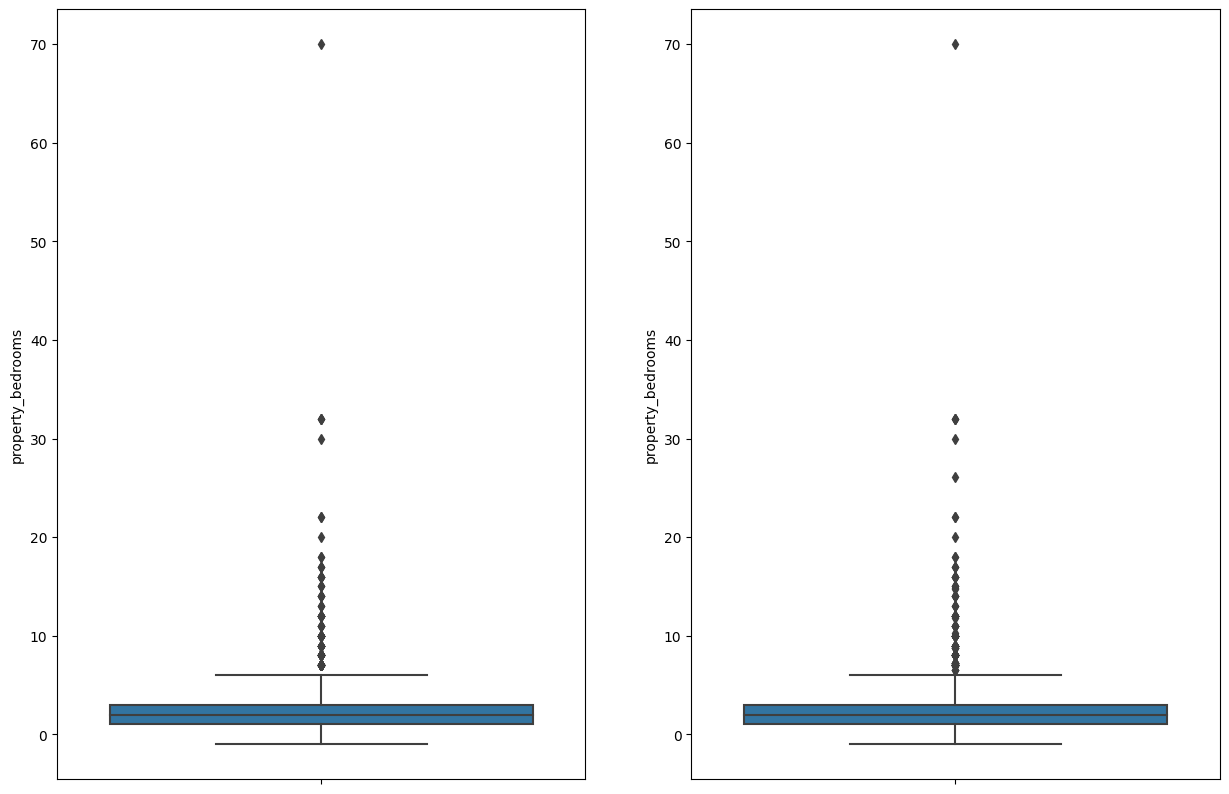

In [1318]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15,10)
sns.boxplot(y="property_bedrooms", data=ds_copia_pre_imputacion, ax=axes[0])
sns.boxplot(y="property_bedrooms", data=ds_train, ax=axes[1])


In [1319]:
################# contar cada habitacion por dataset y comparar, no se ve nada con las barrras

El grafico nos muestra que la mayoria de los valores faltantes se complentan con una sola habitacion


#### Comparamos property_rooms

<AxesSubplot:ylabel='property_rooms'>

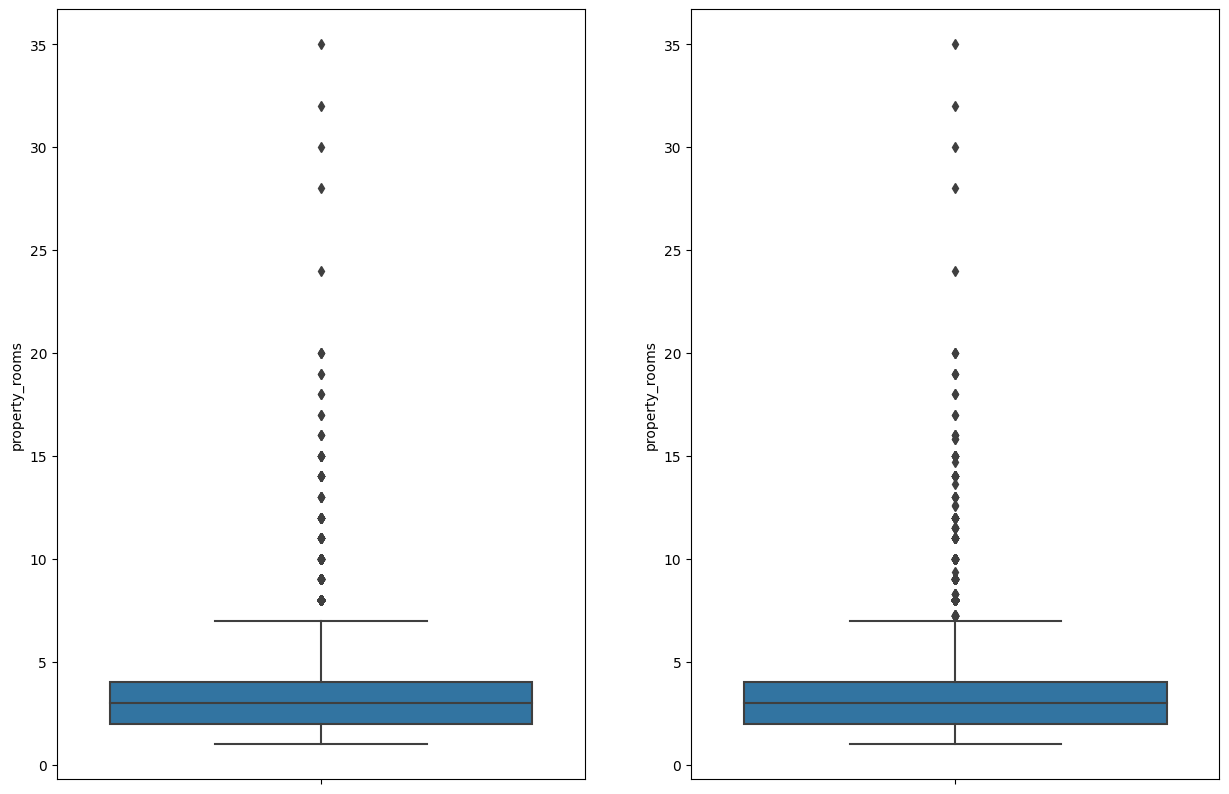

In [1320]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15,10)
sns.boxplot(y="property_rooms", data=ds_copia_pre_imputacion, ax=axes[0])
sns.boxplot(y="property_rooms", data=ds_train, ax=axes[1])


<AxesSubplot:>

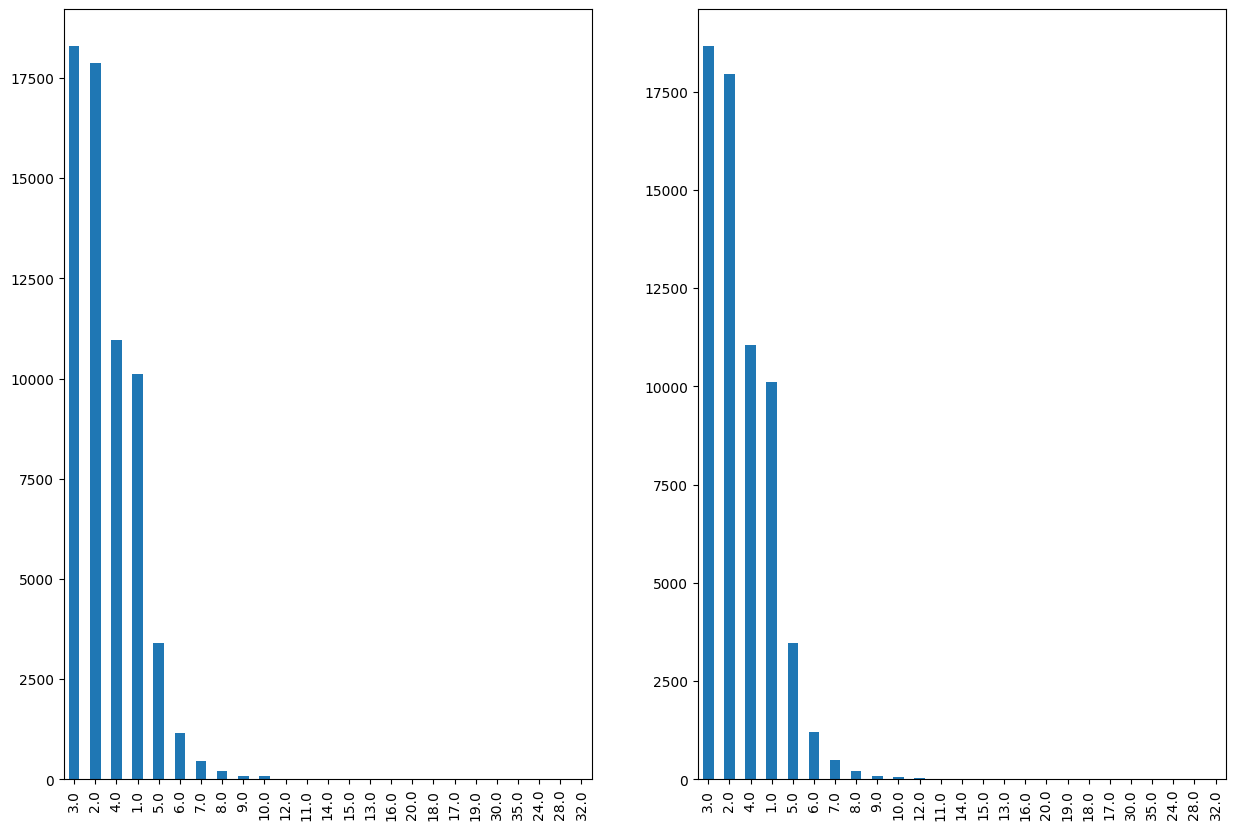

In [1321]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15,10)
ds_copia_pre_imputacion["property_rooms"].value_counts().plot.bar(ax=axes[0])
ds_train["property_rooms"].round().value_counts().plot.bar(ax=axes[1])

Podemos observar que hay un leve incremento en las propiedades con ###

hay que llegar a una conclusion, pero los graficos son complicados, hacer depsues 

#### Comparamos property_surface_total

<AxesSubplot:ylabel='property_surface_total'>

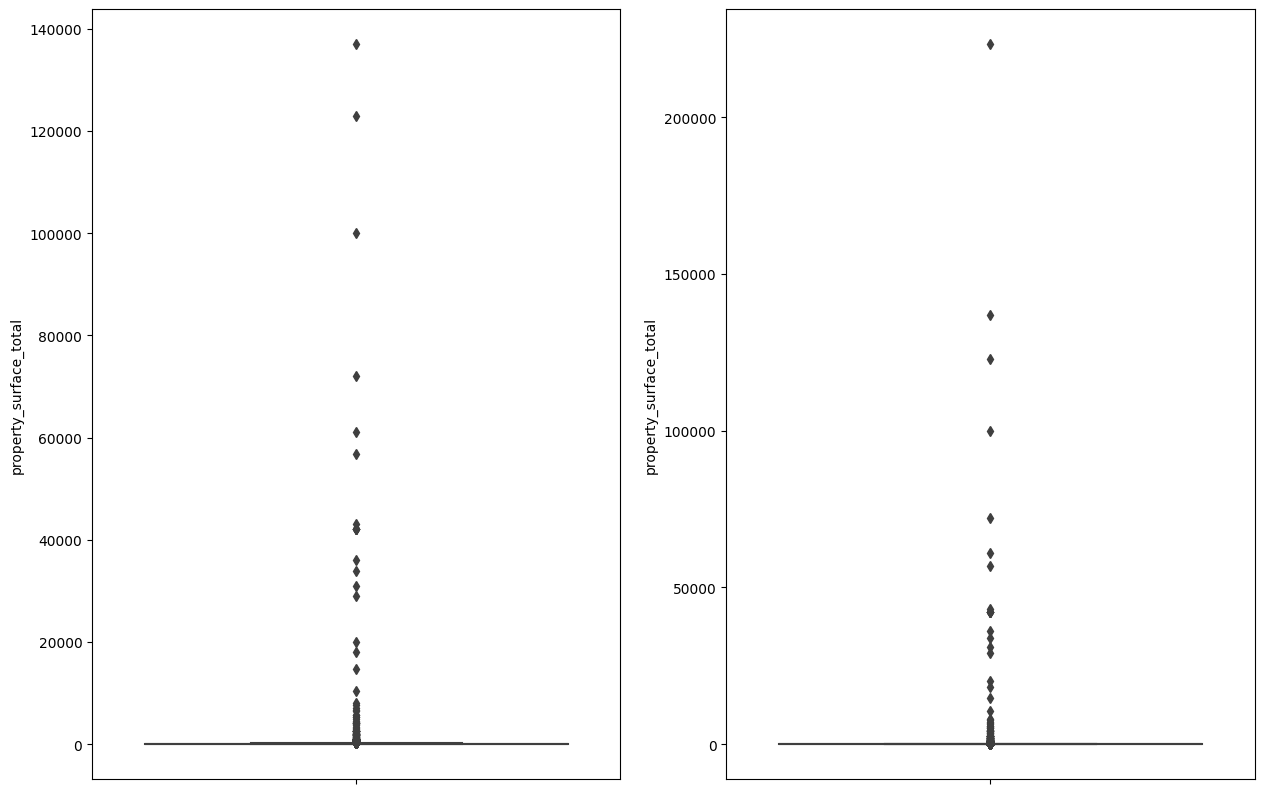

In [1322]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15,10)
sns.boxplot(y="property_surface_total", data=ds_copia_pre_imputacion, ax=axes[0])
sns.boxplot(y="property_surface_total", data=ds_train, ax=axes[1])


In [1323]:
promedio_pre_imputacion = ds_copia_pre_imputacion["property_surface_total"].mean()
promedio_post_imputacion = ds_train["property_surface_total"].mean()

print("El promedio pre imputacion de la variable property_surface_total tiene un valor de: " + str(promedio_pre_imputacion))
print("El promedio post imputacion de la variable property_surface_total tiene un valor de: " + str(promedio_post_imputacion))

El promedio pre imputacion de la variable property_surface_total tiene un valor de: 109.10674017369357
El promedio post imputacion de la variable property_surface_total tiene un valor de: 113.01639042092367


Podemos observar que es muy parecido el promedio observado por los dos datasets, pero el post imputacion es un poco mas grande. 

#### Comparamos property_surface_covered

<AxesSubplot:ylabel='property_surface_covered'>

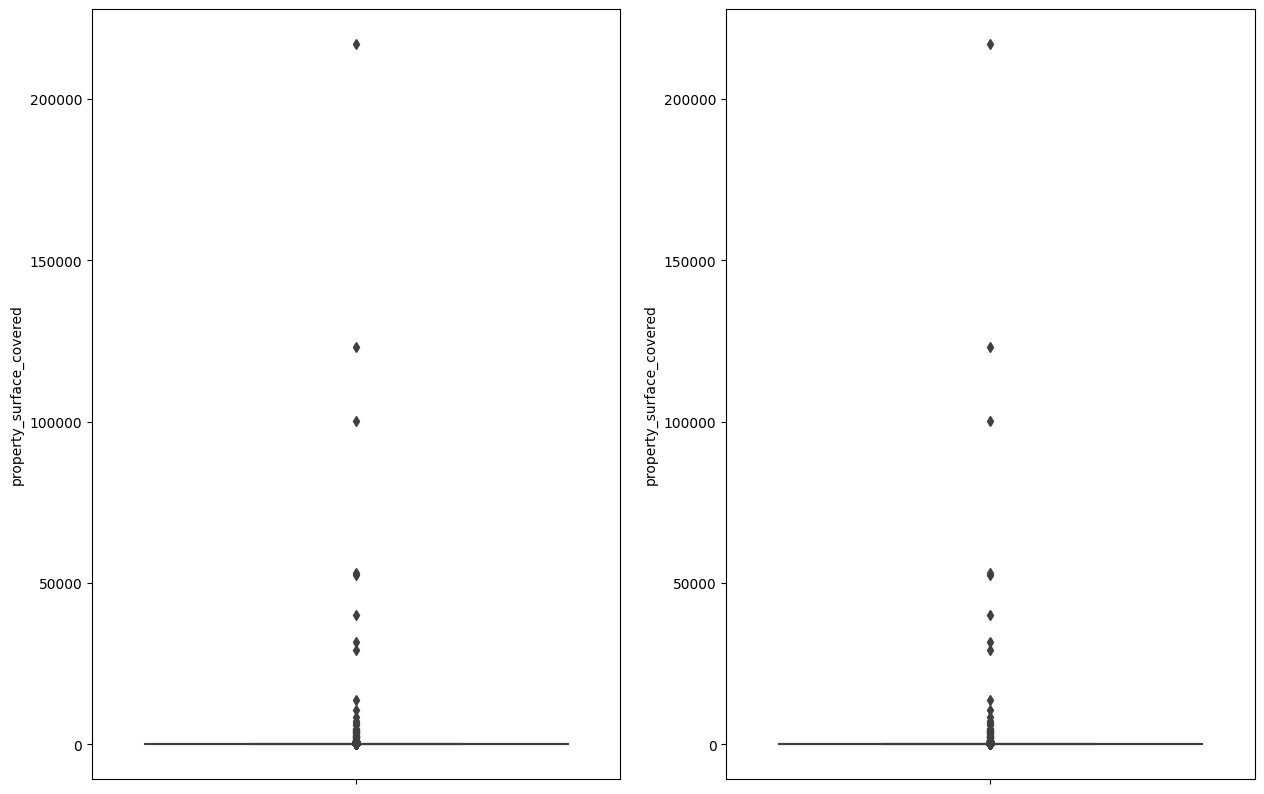

In [1241]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15,10)
sns.boxplot(y="property_surface_covered", data=ds_copia_pre_imputacion, ax=axes[0])
sns.boxplot(y="property_surface_covered", data=ds_train, ax=axes[1])


In [1242]:
promedio_pre_imputacion = ds_copia_pre_imputacion["property_surface_covered"].mean()
promedio_post_imputacion = ds_train["property_surface_covered"].mean()

print("El promedio pre imputacion de la variable property_surface_covered tiene un valor de: " + str(promedio_pre_imputacion))
print("El promedio post imputacion de la variable property_surface_covered tiene un valor de: " + str(promedio_post_imputacion))

El promedio pre imputacion de la variable property_surface_covered tiene un valor de: 88.81285336122096
El promedio post imputacion de la variable property_surface_covered tiene un valor de: 88.32823860322772


En este caso es lo contrario, el promedio post imputacion tiene un valor mas bajo, aunque muy pequeno.

## Analizar la existencia de valores atípicos


### Detectar valores atípicos en los datos en forma univariada


Preparamos el dataset


In [198]:
ds_atipicos = mice.copy()
ds_atipicos_copia = mice.copy()
columnas_a_eliminar = ["start_date", "end_date", "created_on", "latitud", "longitud", "place_l2", "place_l3", "operation", "property_type", "property_currency", "property_title"]
ds_atipicos.drop(columns = columnas_a_eliminar, inplace=True)

Analizamos property_rooms


In [199]:
#z-score Rooms con librería stats
ds_atipicos['z_rooms']=st.zscore(ds_atipicos.property_rooms) #Agregamos columna con valores de z-score

#z-score modificado Rooms con librería stats
mediana_rooms = np.median(ds_atipicos.property_rooms)
MAD=np.median(np.absolute(ds_atipicos.property_rooms - mediana_rooms)) #Mediana de los desvios absolutos
ds_atipicos['zm_rooms']=(ds_atipicos.property_rooms - mediana_rooms)*0.6745/MAD

Una vez realizado el calculo vemos aquellas muestras que no respetan la "regla de oro"


In [200]:
ds_atipicos[ds_atipicos['z_rooms'] > 3 ]

property_rooms  property_bedrooms  property_surface_total  \
9661              12.0                5.0              435.000000   
201345             9.0                8.0              397.187864   
22023              8.0                7.0              750.000000   
197660             9.0                5.0              408.544993   
331525             8.0                6.0              166.000000   
...                ...                ...                     ...   
196894             8.0                5.0              277.000000   
117511             9.0                4.0              500.000000   
170999             8.0                5.0              316.000000   
421588             8.0                7.0              440.000000   
171766             8.0                6.0              205.000000   

        property_surface_covered  property_price   z_rooms  zm_rooms  
9661                  435.000000        850000.0  6.405684    6.0705  
201345                290.000000        400000.0  4.308970    4.0470  
22023                 750.000000       1500000.0  3.610066    3.3725  
197660                330.000000       1250000.0  4.308970    4.0470  
331525                144.000000        190000.0  3.610066    3.3725  
...                          ...             ...       ...       ...  
196894                277.000000        640000.0  3.610066    3.3725  
117511                500.000000       2250000.0  4.308970    4.0470  
170999                296.588937       1200000.0  3.610066    3.3725  
421588                235.000000        260000.0  3.610066    3.3725  
171766                190.000000        300000.0  3.610066    3.3725  

[629 rows x 7 columns]

In [201]:
ds_atipicos[ds_atipicos['z_rooms'] < -3 ]

Empty DataFrame
Columns: [property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms, zm_rooms]
Index: []

Grafico Boxplot


<AxesSubplot:ylabel='property_rooms'>

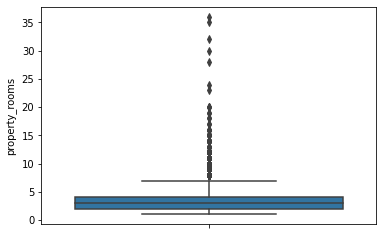

In [202]:
sns.boxplot(y=ds_atipicos.property_rooms)

Anlalizamos property_bedrooms


In [203]:
#z-score
ds_atipicos['z_bedrooms']=st.zscore(ds_atipicos.property_bedrooms)

#z-score modificado
mediana_bedrooms = np.median(ds_atipicos.property_bedrooms)
MAD=np.median(np.absolute(ds_atipicos.property_bedrooms - mediana_bedrooms)) #Mediana de los desvios absolutos
ds_atipicos['zm_bedrooms']=(ds_atipicos.property_bedrooms - mediana_bedrooms)*0.6745/MAD

Una vez realizado el calculo vemos aquellas muestras que no respetan la "regla de oro" y sean posibles outliers


In [204]:
ds_atipicos[ds_atipicos['z_bedrooms'] > 3 ]

property_rooms  property_bedrooms  property_surface_total  \
346603             7.0                6.0              244.000000   
340949             7.0                6.0              239.348170   
236625             7.0                6.0              296.634914   
201345             9.0                8.0              397.187864   
22023              8.0                7.0              750.000000   
...                ...                ...                     ...   
292695             8.0                7.0              398.000000   
327194             8.0                6.0              694.092132   
432687             6.0                6.0              155.000000   
421588             8.0                7.0              440.000000   
171766             8.0                6.0              205.000000   

        property_surface_covered  property_price   z_rooms  zm_rooms  \
346603                     244.0        260000.0  2.911161    2.6980   
340949                     160.0        380000.0  2.911161    2.6980   
236625                     215.0        430000.0  2.911161    2.6980   
201345                     290.0        400000.0  4.308970    4.0470   
22023                      750.0       1500000.0  3.610066    3.3725   
...                          ...             ...       ...       ...   
292695                     277.0        399000.0  3.610066    3.3725   
327194                     600.0        820000.0  3.610066    3.3725   
432687                     120.0        250000.0  2.212257    2.0235   
421588                     235.0        260000.0  3.610066    3.3725   
171766                     190.0        300000.0  3.610066    3.3725   

        z_bedrooms  zm_bedrooms  
346603    3.607570       2.6980  
340949    3.607570       2.6980  
236625    3.607570       2.6980  
201345    5.373931       4.0470  
22023     4.490750       3.3725  
...            ...          ...  
292695    4.490750       3.3725  
327194    3.607570       2.6980  
432687    3.607570       2.6980  
421588    4.490750       3.3725  
171766    3.607570       2.6980  

[449 rows x 9 columns]

In [205]:
ds_atipicos[ds_atipicos['z_bedrooms'] < -3 ]

Empty DataFrame
Columns: [property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms, zm_rooms, z_bedrooms, zm_bedrooms]
Index: []

Grafico


<AxesSubplot:ylabel='property_bedrooms'>

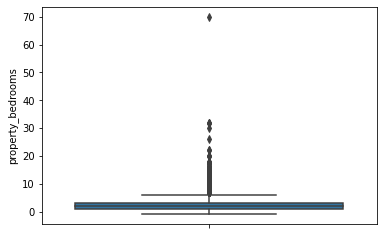

In [206]:
sns.boxplot(y=ds_atipicos.property_bedrooms)

Analizamos property_surface_total


In [207]:
ds_atipicos['z_surface_total']=st.zscore(ds_atipicos.property_surface_total)

Una vez realizado el calculo vemos aquellas muestras que no respetan la "regla de oro" y sean posibles outliers


In [208]:
ds_atipicos[ds_atipicos['z_surface_total'] > 3 ]

property_rooms  property_bedrooms  property_surface_total  \
370919             5.0                4.0            42110.000000   
370921             5.0                4.0            42110.000000   
459842             3.0                2.0             8136.000000   
189057             4.0                3.0             4200.000000   
84073              1.0                1.0            36000.000000   
106598             2.0                1.0            56740.000000   
459847             4.0                3.0            18096.000000   
400155             2.0                1.0             4632.000000   
370932             4.0                3.0            42110.000000   
370918             4.0                3.0            42110.000000   
370922             5.0                4.0            42110.000000   
352883             1.0                1.0            29064.000000   
362741             1.0                1.0            31000.000000   
129214             5.0                3.0           137000.000000   
293109             3.0                2.0             5239.000000   
233699             2.0                1.0             4224.000000   
314541             1.0                1.0             5741.000000   
372779             4.0                3.0           100068.000000   
72316              2.0                1.0            61130.000000   
117835             2.0                1.0            43086.000000   
459841             3.0                2.0             7153.000000   
304492             1.0                1.0            31000.000000   
356064             3.0                2.0            60000.000000   
275253             1.0                1.0            31000.000000   
149946             3.0                2.0             5736.000000   
370920             5.0                4.0            42110.000000   
405324             4.0                3.0           123000.000000   
459588             3.0                2.0             6609.000000   
72521              2.0                1.0            33800.000000   
459849             3.0                2.0             7720.000000   
324541             4.0                3.0            20041.000000   
237392             4.0                3.0            20041.000000   
189042             5.0                4.0             5000.000000   
126869             1.0                1.0            31000.000000   
33017              1.0                1.0             4428.000000   
1140               4.0                3.0            10500.000000   
94789              2.0                1.0             5312.000000   
1932              23.0               18.0           223411.082089   
370917             4.0                3.0            42110.000000   
398069             2.0                1.0             6470.000000   
264624             5.0                4.0            14744.000000   
219021             4.0                3.0            72060.000000   
34123              4.0                3.0             5000.000000   
353009             1.0                1.0            31000.000000   
300394             1.0                1.0            31000.000000   

        property_surface_covered  property_price    z_rooms  zm_rooms  \
370919                307.000000       3044250.0   1.513352    1.3490   
370921                307.000000       2890500.0   1.513352    1.3490   
459842               6472.000000        203550.0   0.115543    0.0000   
189057                450.000000        850000.0   0.814448    0.6745   
84073                  30.000000         90000.0  -1.282266   -1.3490   
106598              52540.000000        175000.0  -0.583361   -0.6745   
459847               8568.000000        324558.0   0.814448    0.6745   
400155                 42.000000        129000.0  -0.583361   -0.6745   
370932                307.000000       1691800.0   0.814448    0.6745   
370918                307.000000       1568760.0   0.814448    0.6745   
370922                307.0000

Grafico


<AxesSubplot:ylabel='property_surface_total'>

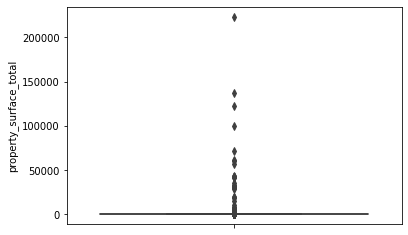

In [209]:
sns.boxplot(y=ds_atipicos.property_surface_total)

Analizamos property_surface_covered


In [210]:
ds_atipicos['z_surface_covered']=st.zscore(ds_atipicos.property_surface_covered)


Una vez realizado el calculo vemos aquellas muestras que no respetan la "regla de oro" y sean posibles outliers


In [211]:
ds_atipicos[ds_atipicos['z_surface_covered'] > 3 ]

property_rooms  property_bedrooms  property_surface_total  \
459842             3.0                2.0             8136.000000   
106598             2.0                1.0            56740.000000   
459847             4.0                3.0            18096.000000   
352883             1.0                1.0            29064.000000   
293109             3.0                2.0             5239.000000   
233699             2.0                1.0             4224.000000   
314541             1.0                1.0             5741.000000   
85725              5.0                4.0             3197.000000   
372779             4.0                3.0           100068.000000   
72316              2.0                1.0            61130.000000   
117835             2.0                1.0            43086.000000   
459841             3.0                2.0             7153.000000   
311702             2.0                1.0             3939.000000   
405324             4.0                3.0           123000.000000   
30359              2.0                1.0               48.000000   
72521              2.0                1.0            33800.000000   
187888             2.0                1.0             3425.000000   
459849             3.0                2.0             7720.000000   
354376             3.0                2.0               41.000000   
1140               4.0                3.0            10500.000000   
94789              2.0                1.0             5312.000000   
1932              23.0               18.0           223411.082089   
398069             2.0                1.0             6470.000000   
264624             5.0                4.0            14744.000000   

        property_surface_covered  property_price    z_rooms  zm_rooms  \
459842               6472.000000        203550.0   0.115543    0.0000   
106598              52540.000000        175000.0  -0.583361   -0.6745   
459847               8568.000000        324558.0   0.814448    0.6745   
352883              29064.000000         87400.0  -1.282266   -1.3490   
293109               3287.818856        119000.0   0.115543    0.0000   
233699               4224.000000        100000.0  -0.583361   -0.6745   
314541               4276.000000         85144.0  -1.282266   -1.3490   
85725                3367.000000      12000000.0   1.513352    1.3490   
372779             100051.000000        420000.0   0.814448    0.6745   
72316               53030.000000        225000.0  -0.583361   -0.6745   
117835              40038.000000        114000.0  -0.583361   -0.6745   
459841               7153.000000        177807.0   0.115543    0.0000   
311702               3939.000000         64000.0  -0.583361   -0.6745   
405324             123000.000000        165000.0   0.814448    0.6745   
30359                4435.000000         93500.0  -0.583361   -0.6745   
72521               31670.000000         66000.0  -0.583361   -0.6745   
187888               3425.000000         75000.0  -0.583361   -0.6745   
459849               5970.000000        167894.0   0.115543    0.0000   
354376               3837.000000         83000.0   0.115543    0.0000   
1140                10500.000000       9900000.0   0.814448    0.6745   
94789                4809.000000        145000.0  -0.583361   -0.6745   
1932               217000.000000        250000.0  14.093633   13.4900   
398069               4664.000000        149900.0  -0.583361   -0.6745   
264624              13717.000000        330000.0   1.513352    1.3490   

        z_bedrooms  zm_bedrooms  z_surface_total  z_surface_covered  
459842    0.074849       0.0000         5.985858           6.114210  
106598   -0.808332      -0.6745        42.261169          50.237945  
459847    0.958029       0.6745        13.419446           8.121750  
352883   -0.808332      -0.6745        21.605349          27.752732  
293109    0.074849       0.0000         3.823699           3.064415  
233699   -0.808332      -0.6745     

Grafico


<AxesSubplot:ylabel='property_surface_covered'>

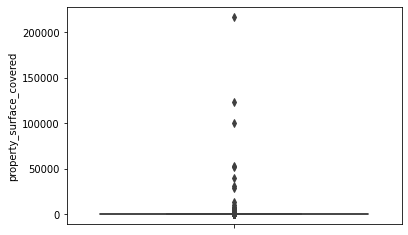

In [212]:
sns.boxplot(y=ds_atipicos.property_surface_covered)

Analizamos property_price


In [213]:
#z-score
ds_atipicos['z_price']=st.zscore(ds_atipicos.property_price)

#z-score modificado
mediana_price = np.median(ds_atipicos.property_price)
MAD=np.median(np.absolute(ds_atipicos.property_price - mediana_price)) 
ds_atipicos['zm_price']=(ds_atipicos.property_price - mediana_price)*0.6745/MAD

Una vez realizado el calculo vemos aquellas muestras que no respetan la "regla de oro" y sean posibles outliers


In [214]:
ds_atipicos[ds_atipicos['z_price'] > 3 ]

property_rooms  property_bedrooms  property_surface_total  \
210381             6.0                5.0                   500.0   
224133             6.0                5.0                   550.0   
229380             4.0                2.0                   220.0   
301217             3.0                2.0                   466.0   
275653             4.0                3.0                   346.0   
...                ...                ...                     ...   
392471             6.0                3.0                   276.0   
342069             4.0                3.0                   334.0   
313226             5.0                3.0                   400.0   
259715             4.0                3.0                   224.0   
81899              6.0                4.0                   390.0   

        property_surface_covered  property_price   z_rooms  zm_rooms  \
210381                     470.0       2950000.0  2.212257    2.0235   
224133                     550.0       1580000.0  2.212257    2.0235   
229380                     220.0       1680000.0  0.814448    0.6745   
301217                     319.0       3000000.0  0.115543    0.0000   
275653                     328.0       2000000.0  0.814448    0.6745   
...                          ...             ...       ...       ...   
392471                     276.0       1350000.0  2.212257    2.0235   
342069                     334.0       2500000.0  0.814448    0.6745   
313226                     390.0       2844000.0  1.513352    1.3490   
259715                     211.0       1250000.0  0.814448    0.6745   
81899                      390.0       2700000.0  2.212257    2.0235   

        z_bedrooms  zm_bedrooms  z_surface_total  z_surface_covered   z_price  \
210381    2.724390       2.0235         0.286774           0.365520  8.383816   
224133    2.724390       2.0235         0.324091           0.442144  4.165426   
229380    0.074849       0.0000         0.077798           0.126071  4.473337   
301217    0.074849       0.0000         0.261399           0.220893  8.537772   
275653    0.958029       0.6745         0.171837           0.229513  5.458655   
...            ...          ...              ...                ...       ...   
392471    0.958029       0.6745         0.119593           0.179708  3.457229   
342069    0.958029       0.6745         0.162881           0.235260  6.998213   
313226    0.958029       0.6745         0.212140           0.288897  8.057429   
259715    0.958029       0.6745         0.080783           0.117451  3.149317   
81899     1.841209       1.3490         0.204676           0.288897  7.614036   

         zm_price  
210381  32.631845  
224133  16.699690  
229380  17.862621  
301217  33.213310  
275653  21.584000  
...           ...  
392471  14.024948  
342069  27.398655  
313226  31.399138  
259715  12.862017  
81899   29.724517  

[1267 rows x 13 columns]

Grafico


<AxesSubplot:ylabel='property_price'>

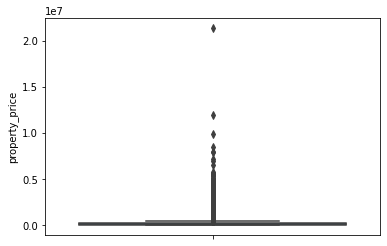

In [215]:
sns.boxplot(y=ds_atipicos.property_price)

### Detectar valores atípicos en los datos en forma multivariada


Utilizamos el metodo de Isolation Forest


In [216]:
from sklearn.ensemble import IsolationForest
#Creo el modelo
iforest = IsolationForest(n_estimators=100, max_samples='auto', 
                          contamination=0.05, max_features=5, 
                          bootstrap=False, n_jobs=-1, random_state=1)

Entreno y genero la predicción


In [217]:

ds_forest = ds_atipicos.drop(columns=["z_rooms","zm_rooms","z_bedrooms","zm_bedrooms","z_surface_total","z_surface_covered","z_price","zm_price"])
pred = iforest.fit_predict(ds_forest)

/home/fanu/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Almaceno scores y etiquetas


In [218]:

ds_forest['scores']=iforest.decision_function(ds_forest)
ds_forest['outlier_label']=pred

#Observaciones anómalas
ds_forest[ds_forest.outlier_label==-1]

property_rooms  property_bedrooms  property_surface_total  \
210381             6.0                5.0              500.000000   
401702             7.0                5.0              624.000000   
9661              12.0                5.0              435.000000   
363217             6.0                5.0              319.873354   
224133             6.0                5.0              550.000000   
...                ...                ...                     ...   
438827             3.0                2.0              352.000000   
46275              2.0                1.0              260.000000   
361500             7.0                4.0              672.106338   
81899              6.0                4.0              390.000000   
190769             7.0                4.0              292.000000   

        property_surface_covered  property_price    scores  outlier_label  
210381                     470.0       2950000.0 -0.201533             -1  
401702                     624.0       1111111.0 -0.186345             -1  
9661                       435.0        850000.0 -0.178423             -1  
363217                     250.0        320000.0 -0.057714             -1  
224133                     550.0       1580000.0 -0.187063             -1  
...                          ...             ...       ...            ...  
438827                     352.0        300000.0 -0.030188             -1  
46275                      240.0        610000.0 -0.052497             -1  
361500                     600.0        660000.0 -0.163474             -1  
81899                      390.0       2700000.0 -0.145233             -1  
190769                     187.0        430000.0 -0.010911             -1  

[3770 rows x 7 columns]

Cuento la cantidad de obs anomalas


In [219]:
ds_forest.outlier_label.value_counts()

 1    71629
-1     3770
Name: outlier_label, dtype: int64

Graficos de valores atipicos relacionando las columnas del dataset


#### property_price vs property_rooms


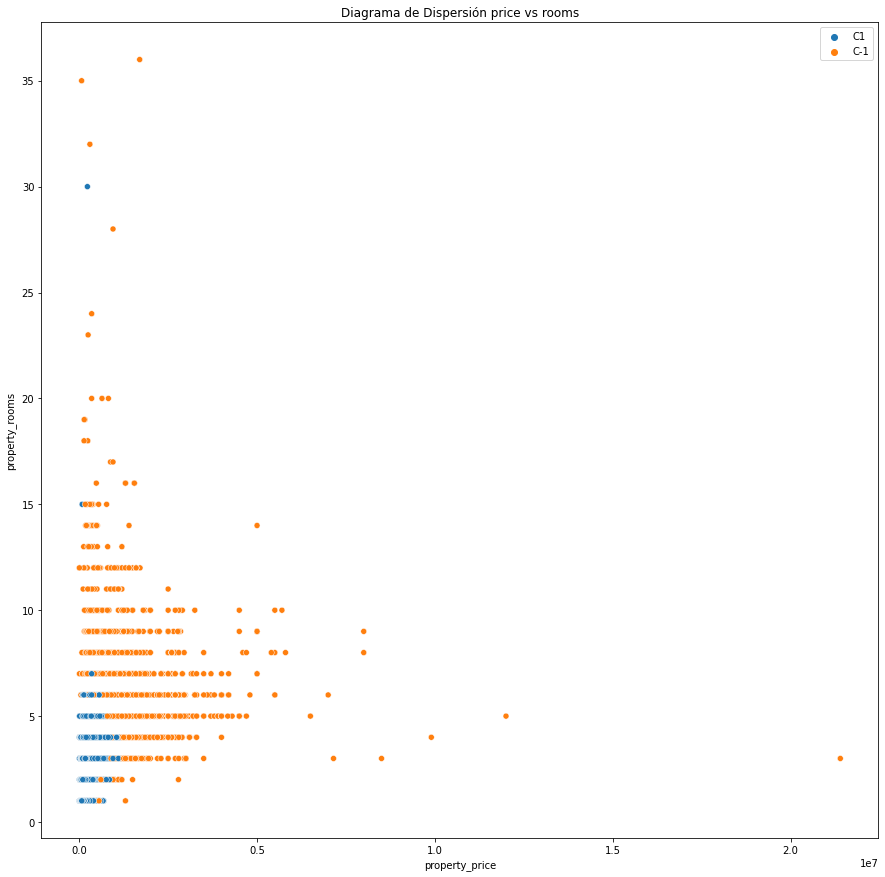

In [220]:
#Grafico dispersograma
color=[f"C{n}" for n in (ds_forest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(x=ds_forest['property_price'],y=ds_forest['property_rooms'],hue=color)
plt.title('Diagrama de Dispersión price vs rooms')
plt.show()

#### property_bedrooms vs property_rooms


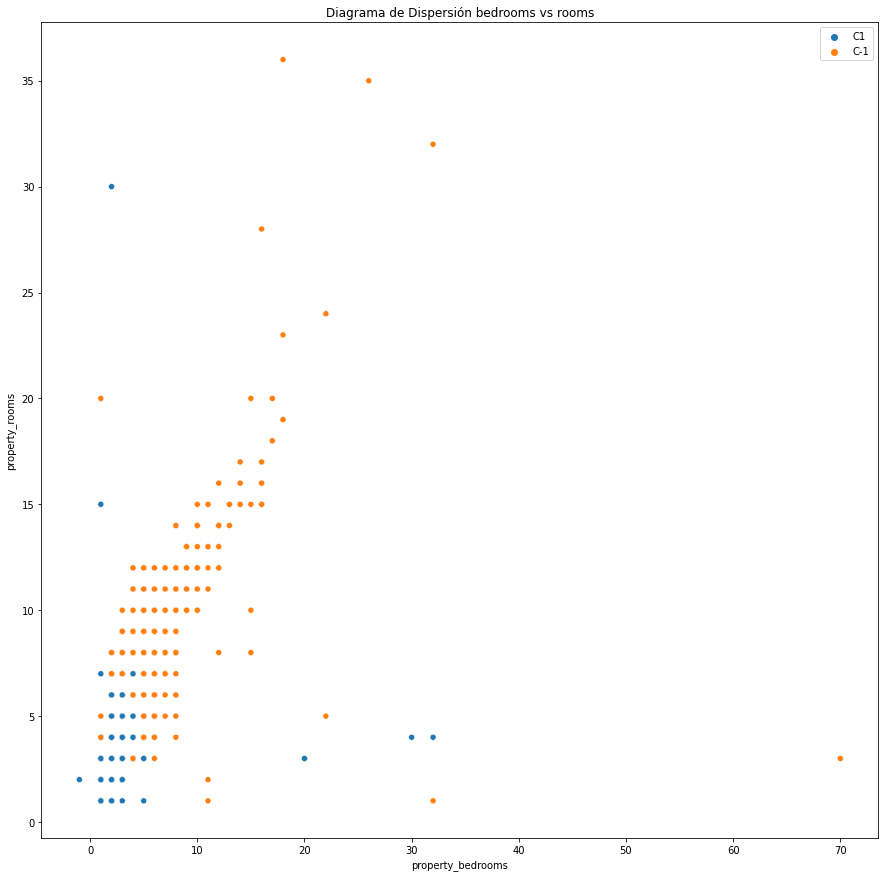

In [221]:
#Grafico dispersograma
color=[f"C{n}" for n in (ds_forest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(x=ds_forest['property_bedrooms'],y=ds_forest['property_rooms'],hue=color)
plt.title('Diagrama de Dispersión bedrooms vs rooms')
plt.show()

#### property_price vs property_surface_covered


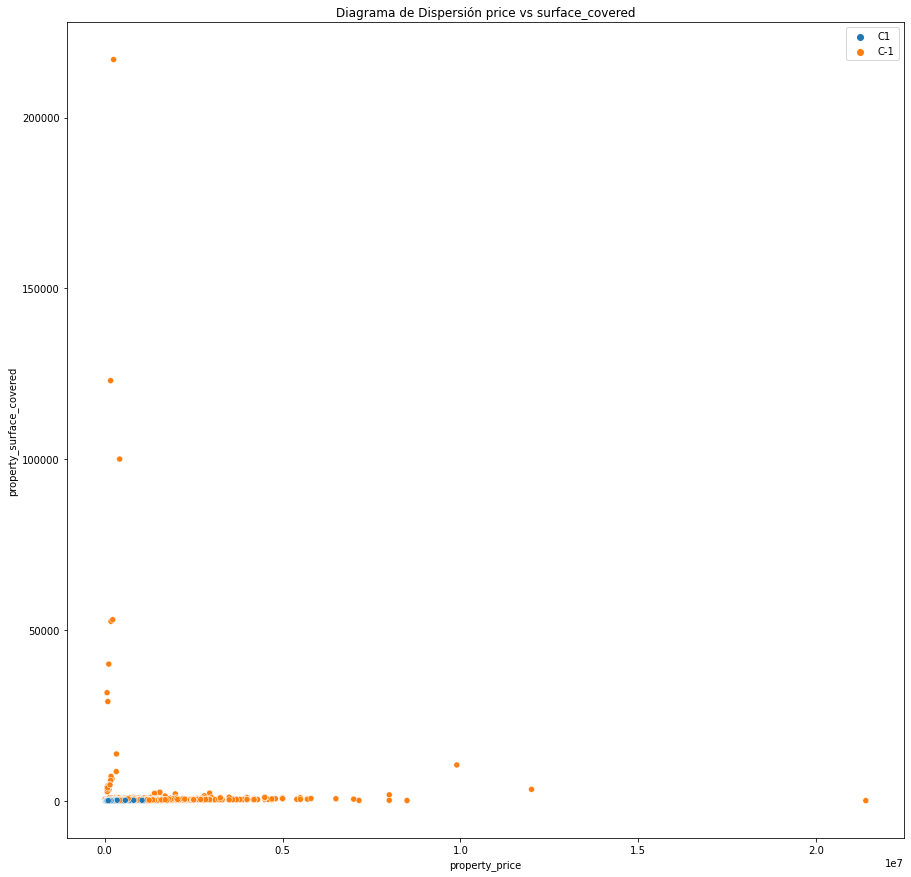

In [222]:
#Grafico dispersograma
color=[f"C{n}" for n in (ds_forest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(x=ds_forest['property_price'],y=ds_forest['property_surface_covered'],hue=color)
plt.title('Diagrama de Dispersión price vs surface_covered')
plt.show()

#### property_price vs property_surface_total


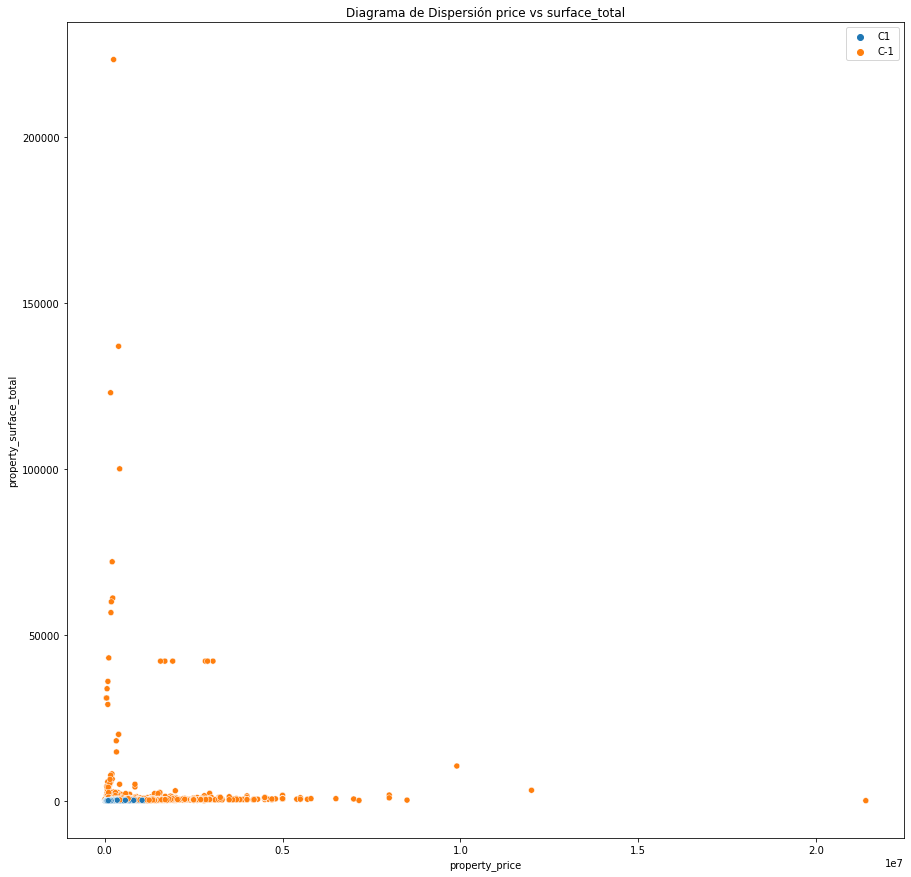

In [223]:
#Grafico dispersograma
color=[f"C{n}" for n in (ds_forest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(x=ds_forest['property_price'],y=ds_forest['property_surface_total'],hue=color)
plt.title('Diagrama de Dispersión price vs surface_total')
plt.show()

### Caracterisicas de los datos atipicos detectados

Los datos atipicos encontrados de forma univariada tienen la caracteristica que tiene tres o mas desviaciones estándar de la media muestral 
Los datos atipicos detectados de forma multivariada, tienen la caracteristica de ser un valor extremo, pero cuando se lo considera con otra variable, por ejemplo si un departamento tiene un precio extremadamente alto y solo 1 habitacion, o en el caso contrario, de ser un departamento de 10 habitaciones con un precio muy bajo.

### Características y tratamientos de los datos atípicos detectados.


Con los analisis univariados y multivariados que analizamos, concluimos que la mayoria de los datos atipicos los encontramos en valores relacionados con las variables "property_bedrooms", "property_rooms" y "property_price".

Luego de los distintos análisis del dataset pudimos obvservar que al aplicar el método univariado encontramos aquellos outliers con valores extremos en relación a cada columna en particular. En cambio, al implementar el modelo de Isolation Forest para valores atípicos multivariados obtuvimos otras muestras a tener en cuenta como outliers para un mejor tratamiento de los mismos.

Decidimos eliminar solo aquellos valores atipicos, que encontramos en el analisis multivariado y univariado de "property_bedrooms", "property_rooms" y "property_price", esta decision la tomamos debido a que la coincidencia de el analisis univariado y multivariado nos da una certeza mas alta de que verdaderamente estamos eliminando valores erroneos.

En cuanto al analisis de "property_surface_covered" y "property_surface_total" decidimos eliminar todos los valores atipicos obtenidos con el modelo z-score


Eliminacion de valores atipicos detectados en forma univariada de surface_total & surface_covered


In [224]:
indice_surface_total = ds_atipicos[ds_atipicos['z_surface_total'] > 3 ].index.to_list()
indice_surface_covered = ds_atipicos[ds_atipicos['z_surface_covered'] > 3 ].index.to_list()
indice_a_eliminar_directo = indice_surface_total + indice_surface_covered
ds_atipicos = ds_atipicos.drop(index=indice_a_eliminar_directo)

Eliminacion de valores atipicos coincidentes en ambos metodos


In [225]:
from collections import OrderedDict
from iteration_utilities import duplicates # hay que instalar iteration_utilities "pip install iteration_utilities"
from iteration_utilities import unique_everseen
indice_price = ds_atipicos[ds_atipicos['z_price'] > 3 ].index.to_list()
indice_bedrooms = ds_atipicos[ds_atipicos['z_bedrooms'] > 3 ].index.to_list()
indice_rooms = ds_atipicos[ds_atipicos['z_rooms'] > 3 ].index.to_list()
indice_multi_variable = ds_forest[ds_forest.outlier_label==-1].index.to_list()
indice_a_eliminar = indice_price + indice_bedrooms + indice_rooms
indice_a_eliminar = list(OrderedDict.fromkeys(indice_a_eliminar))
indice_a_eliminar = indice_a_eliminar + indice_multi_variable
a = list(unique_everseen(duplicates(indice_a_eliminar)))
ds_atipicos = ds_atipicos.drop(index=a)
ds_atipicos_copia = ds_atipicos_copia.drop(index = a)

### Analizar la relación entre el precio de venta y los metros de superficie


volvemos a hacer el analisis despues de la depuracion


In [226]:
iforest = IsolationForest(n_estimators=100, max_samples='auto', 
                          contamination=0.05, max_features=5, 
                          bootstrap=False, n_jobs=-1, random_state=1)

Entreno y genero la predicción


In [227]:

ds_forest = ds_atipicos.drop(columns=["z_rooms","zm_rooms","z_bedrooms","zm_bedrooms","z_surface_total","z_surface_covered","z_price","zm_price"])
pred = iforest.fit_predict(ds_forest)

/home/fanu/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [228]:
ds_forest['scores']=iforest.decision_function(ds_forest)
ds_forest['outlier_label']=pred

#Observaciones anómalas
ds_forest[ds_forest.outlier_label==-1]

property_rooms  property_bedrooms  property_surface_total  \
413132             5.0                3.0              290.000000   
354298             5.0                4.0              254.000000   
401702             7.0                5.0              624.000000   
349977             5.0                4.0              270.000000   
106900             4.0                2.0              210.000000   
...                ...                ...                     ...   
46275              2.0                1.0              260.000000   
438440             6.0                4.0              300.000000   
361500             7.0                4.0              672.106338   
190769             7.0                4.0              292.000000   
237552             7.0                4.0              214.000000   

        property_surface_covered  property_price    scores  outlier_label  
413132                     230.0        815000.0 -0.075728             -1  
354298                     245.0        750000.0 -0.059887             -1  
401702                     624.0       1111111.0 -0.210288             -1  
349977                     265.0        669000.0 -0.062640             -1  
106900                     201.0        790000.0 -0.045979             -1  
...                          ...             ...       ...            ...  
46275                      240.0        610000.0 -0.076214             -1  
438440                     224.0        350000.0 -0.054517             -1  
361500                     600.0        660000.0 -0.186984             -1  
190769                     187.0        430000.0 -0.083309             -1  
237552                     186.0        350000.0 -0.053468             -1  

[3678 rows x 7 columns]

cantidad de obs. anómalas


In [229]:
ds_forest.outlier_label.value_counts()

 1    69867
-1     3678
Name: outlier_label, dtype: int64

Grafico dispersograma


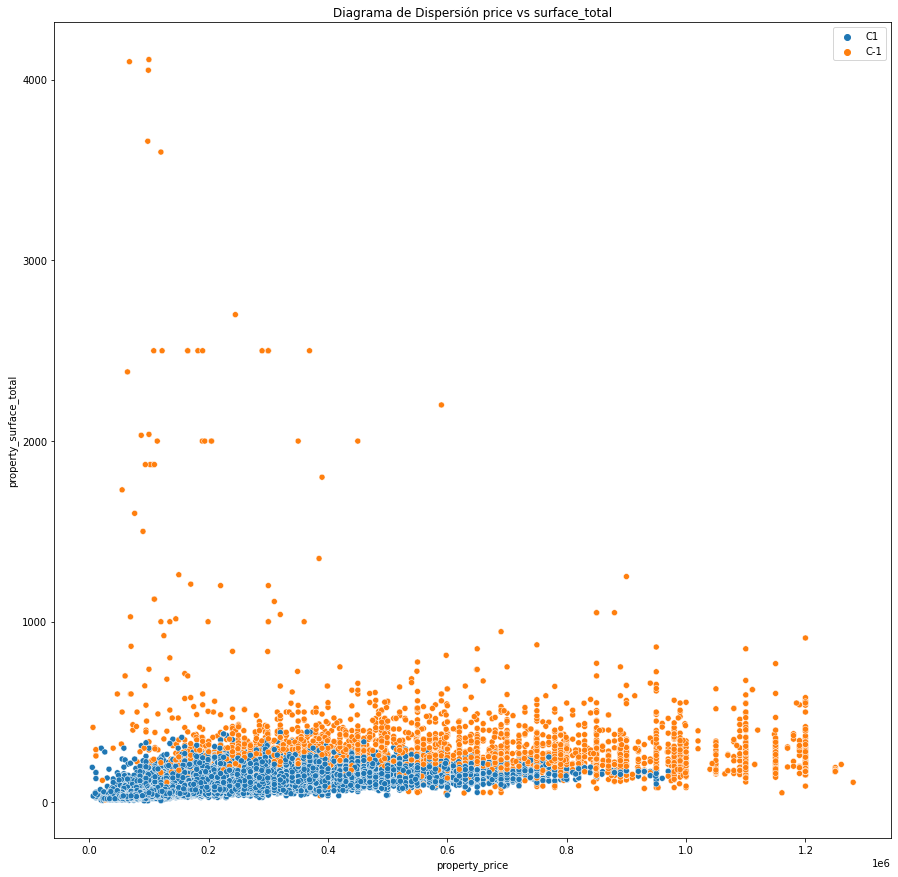

In [230]:
color=[f"C{n}" for n in (ds_forest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(x=ds_forest['property_price'],y=ds_forest['property_surface_total'],hue=color)
plt.title('Diagrama de Dispersión price vs surface_total')
plt.show()

Los outliers en casos multivariados como los que analizamos previamente, pueden provocar un efecto de enmascaramietno que se produce cuando un grupo de outliers esconden a otros. Es decir, los outliers enmascarados se haran visibles cuando se eliminen los outliers que los esconden.
En nuestro caso, observamos como al eliminar la primer tanda de valores atipicos y realizar el analisis nuevamente, encontramos nuevos outliers.


In [235]:
#indice_multi_variable es el index de los outliers que detectamos mas arriba

indice_multi_variable_2 = ds_forest[ds_forest.outlier_label==-1].index.to_list()
nuevos_outliers = []
for i in indice_multi_variable_2:
    if(i not in indice_multi_variable): nuevos_outliers.append(i)
print(len(nuevos_outliers))

1762


Vemos que eliminando los outliers que detectamos mas arriba y volviendo a utilizar Isolation Forest para la deteccion de outliers, detectamos 1762 nuevos outliers.

Analizando el grafico podemos observar que los valores atipicos suelen aparecer donde "property_price" es relativamente bajo y "property_surface_total" alto y viceversa, donde el "property_price" es alto y el "property_surface_total" muy bajo

## Reduccion De La Dimensionalidad


In [70]:
#Creamos el dataset que será utilizado para la reducción y uliminamos todas las filas con columnas vacías
ds_prop_reducido = ds_atipicos_copia.copy()
ds_prop_reducido = ds_prop_reducido.dropna()

Comenzamos eliminando las variables que ya sabemos no tienen influencia en el precio


In [71]:
variables_eliminadas = ["start_date", "end_date", "created_on", "property_title"]
ds_prop_reducido = ds_prop_reducido.drop(variables_eliminadas, axis='columns', inplace=False)

#Estado del dataset reducido
ds_prop_reducido.head()

latitud   longitud         place_l2     place_l3 operation  \
161952 -34.540279 -58.464803  Capital Federal        Nuñez     Venta   
308773 -34.606780 -58.391341  Capital Federal  San Nicolás     Venta   
367023 -34.569511 -58.456376  Capital Federal   Colegiales     Venta   
180464 -34.587250 -58.446779  Capital Federal    Chacarita     Venta   
362258 -34.606312 -58.493226  Capital Federal     Floresta     Venta   

       property_type  property_rooms  property_bedrooms  \
161952  Departamento             3.0                2.0   
308773  Departamento             2.0                1.0   
367023  Departamento             4.0                3.0   
180464  Departamento             2.0                1.0   
362258            PH             3.0                2.0   

        property_surface_total  property_surface_covered  property_price  \
161952                    61.0                      56.0        130000.0   
308773                    73.0                      62.0        120000.0   
367023                   157.0                     135.0        400000.0   
180464                    36.0                      36.0         93000.0   
362258                    45.0                      45.0         75000.0   

       property_currency  
161952               USD  
308773               USD  
367023               USD  
180464               USD  
362258               USD

Analizamos Correlaciones


In [72]:
ds_prop_reducido.corr()

latitud  longitud  property_rooms  \
latitud                   1.000000 -0.138511       -0.047615   
longitud                 -0.138511  1.000000       -0.019855   
property_rooms           -0.047615 -0.019855        1.000000   
property_bedrooms        -0.045489 -0.020695        0.905547   
property_surface_total   -0.001038  0.000279        0.091408   
property_surface_covered -0.002924  0.001582        0.101391   
property_price            0.187528  0.087668        0.552753   

                          property_bedrooms  property_surface_total  \
latitud                           -0.045489               -0.001038   
longitud                          -0.020695                0.000279   
property_rooms                     0.905547                0.091408   
property_bedrooms                  1.000000                0.094219   
property_surface_total             0.094219                1.000000   
property_surface_covered           0.104747                0.711898   
property_price                     0.544022                0.077604   

                          property_surface_covered  property_price  
latitud                                  -0.002924        0.187528  
longitud                                  0.001582        0.087668  
property_rooms                            0.101391        0.552753  
property_bedrooms                         0.104747        0.544022  
property_surface_total                    0.711898        0.077604  
property_surface_covered                  1.000000        0.047348  
property_price                            0.047348        1.000000

Se puede ver la fuerte correlación entre 'property_rooms' y property_bedrooms'. Al analizarla, vemos que 'property_rooms' son la cantidad de ambientes del inmueble (habitaciones más el comedor), mientras 'property_bedrooms' hace referencia a la cantidad de dormitorios. Un dormitorio cuenta como habitacion, por lo tanto si aumenta 'property_bedrooms', aumentará 'property_rooms'.
Por lo tanto es claro que hay una posible reducción. Si vamos a la pagina 'https://www.properati.com.ar/data/', el esquema de avisos nos informa que 'property_bedrooms' no es útil para los avisos en Argentina. Asi que elegimos eliminar del dataset 'property_bedrooms'.

Lo mismo sucede con las variables 'property_surface_total' y 'property_surace_covered'. Están fuertemente correlacionadas ya que si aumente property_surface_covered', aumenta 'property_surface_total'. Por lo tanto eliminamos 'property_surface_covered'.


In [73]:
variables_eliminadas = ["property_bedrooms", "property_surface_covered"]
ds_prop_reducido = ds_prop_reducido.drop(variables_eliminadas, axis='columns', inplace=False)

#Estado del dataset reducido
ds_prop_reducido.head()

latitud   longitud         place_l2     place_l3 operation  \
161952 -34.540279 -58.464803  Capital Federal        Nuñez     Venta   
308773 -34.606780 -58.391341  Capital Federal  San Nicolás     Venta   
367023 -34.569511 -58.456376  Capital Federal   Colegiales     Venta   
180464 -34.587250 -58.446779  Capital Federal    Chacarita     Venta   
362258 -34.606312 -58.493226  Capital Federal     Floresta     Venta   

       property_type  property_rooms  property_surface_total  property_price  \
161952  Departamento             3.0                    61.0        130000.0   
308773  Departamento             2.0                    73.0        120000.0   
367023  Departamento             4.0                   157.0        400000.0   
180464  Departamento             2.0                    36.0         93000.0   
362258            PH             3.0                    45.0         75000.0   

       property_currency  
161952               USD  
308773               USD  
367023               USD  
180464               USD  
362258               USD

Analizamos la varianza de atributos


Debido a la filtracion del datset originales, vemos que las variables 'place_l2', 'property_currency' y 'operation' tienen todas el mismo valor. Como son todas iguales, no van a tener peso a la hora de modificar el precio, por lo tanto las eliminamos


In [74]:
variables_eliminadas = ["place_l2", "property_currency", "operation"]
ds_prop_reducido = ds_prop_reducido.drop(variables_eliminadas, axis='columns', inplace=False)

#Estado del dataset reducido
ds_prop_reducido.head()

latitud   longitud     place_l3 property_type  property_rooms  \
161952 -34.540279 -58.464803        Nuñez  Departamento             3.0   
308773 -34.606780 -58.391341  San Nicolás  Departamento             2.0   
367023 -34.569511 -58.456376   Colegiales  Departamento             4.0   
180464 -34.587250 -58.446779    Chacarita  Departamento             2.0   
362258 -34.606312 -58.493226     Floresta            PH             3.0   

        property_surface_total  property_price  
161952                    61.0        130000.0  
308773                    73.0        120000.0  
367023                   157.0        400000.0  
180464                    36.0         93000.0  
362258                    45.0         75000.0

Analizamos la importancia de los atributos


In [75]:
#One Hot Encoding para variables categoricas
variables_reemplazadas = ["property_type", "place_l3"]
ds_prop_arbol = pd.get_dummies(ds_prop_reducido, columns=variables_reemplazadas, drop_first=True)

#Creo dataset con los features que se van a usar para clasificar
variables_eliminadas = ['property_price']
ds_prop_filtrado_x = ds_prop_arbol.drop(variables_eliminadas, axis='columns', inplace=False)

scaler = MinMaxScaler()
ds_prop_filtrado_x["property_surface_total"] = scaler.fit_transform(ds_prop_filtrado_x["property_surface_total"].to_frame())
ds_prop_filtrado_x["longitud"] = scaler.fit_transform(ds_prop_filtrado_x["longitud"].to_frame())
ds_prop_filtrado_x["latitud"] = scaler.fit_transform(ds_prop_filtrado_x["latitud"].to_frame())

#Creo dataset con la variable target

ds_prop_filtrado_y = ds_prop_arbol['property_price'].copy()

x_train, x_test, y_train, y_test = train_test_split(ds_prop_filtrado_x, 
                                                    ds_prop_filtrado_y, 
                                                    test_size=0.2, #proporción 90/10 
                                                    random_state=9) #semilla

tree_model = tree.DecisionTreeClassifier(criterion="entropy",max_depth=20, min_samples_leaf=2)

#Entrenamos el modelo
model = tree_model.fit(X=x_train, y=y_train)
y_pred = model.predict(x_test)

#Calculamos las métricas en el conjunto de evaluación
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE: " + str(rmse))

RMSE: 79432.14885806353


In [76]:
#Importancia de los atributos de mayor a menor
sorted(list(zip(ds_prop_filtrado_x.columns.to_list(), model.feature_importances_)), key=lambda x: -x[1])

[('latitud', 0.3125495139444552),
 ('property_surface_total', 0.31017581501269714),
 ('longitud', 0.2875163289620013),
 ('property_rooms', 0.03567046364453855),
 ('property_type_Departamento', 0.007460754133700837),
 ('place_l3_Caballito', 0.006291175028871747),
 ('property_type_PH', 0.0058785997283340415),
 ('place_l3_Puerto Madero', 0.005637812660867491),
 ('place_l3_Palermo', 0.002680451862228328),
 ('place_l3_Villa Urquiza', 0.0023567925782717438),
 ('place_l3_Recoleta', 0.0020431258029910216),
 ('place_l3_Balvanera', 0.001623975864232946),
 ('place_l3_Barrio Norte', 0.0015355829640297173),
 ('place_l3_Almagro', 0.0014327459199209955),
 ('place_l3_Belgrano', 0.00138557850846621),
 ('place_l3_Flores', 0.0012775400211525918),
 ('place_l3_Villa Crespo', 0.0010163700361087715),
 ('place_l3_Monserrat', 0.0008274901569009769),
 ('place_l3_San Telmo', 0.0008252788641044164),
 ('place_l3_Villa del Parque', 0.0007548551811672822),
 ('place_l3_San Nicolás', 0.0007518330887486464),
 ('place_l

Vemos como las variable 'place_l3' tienen muy poca importancia en el arbol de decision. Por lo tanto, las eliminamos


In [77]:
variables_eliminadas = ["place_l3"]
ds_prop_reducido = ds_prop_reducido.drop(variables_eliminadas, axis='columns', inplace=False)

#Estado del dataset reducido
ds_prop_reducido.head()

latitud   longitud property_type  property_rooms  \
161952 -34.540279 -58.464803  Departamento             3.0   
308773 -34.606780 -58.391341  Departamento             2.0   
367023 -34.569511 -58.456376  Departamento             4.0   
180464 -34.587250 -58.446779  Departamento             2.0   
362258 -34.606312 -58.493226            PH             3.0   

        property_surface_total  property_price  
161952                    61.0        130000.0  
308773                    73.0        120000.0  
367023                   157.0        400000.0  
180464                    36.0         93000.0  
362258                    45.0         75000.0

Hacemos PCA para analizar posibles reducciones


In [78]:
ds_prop_reducido_pca = ds_prop_reducido.copy()

columnas_elegidas = ["latitud", "longitud", "property_rooms", "property_surface_total"]

x = ds_prop_reducido_pca.loc[:, columnas_elegidas].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=4) 
x_transformada = pca.fit_transform(x)

pca_df_aux = pd.DataFrame(data = x_transformada
             , columns = ['cp_1', 'cp_2','cp_3','cp_4'])


print("Variabilidad explicada por cada componente:"  + str(pca.explained_variance_ratio_))

Variabilidad explicada por cada componente:[0.28594817 0.27298118 0.23099145 0.2100792 ]


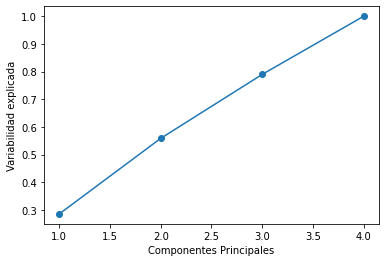

In [79]:
variabilidad_explicada = pca.explained_variance_ratio_
list_x = list(range(1, len(variabilidad_explicada)+1))

# Grafico varianza explicada y cantidad de componentes principales
plt.figure(figsize=(6, 4))
plt.plot(list_x, variabilidad_explicada.cumsum(), '-o')
plt.xlabel(r'Componentes Principales')
plt.ylabel('Variabilidad explicada')
plt.show()

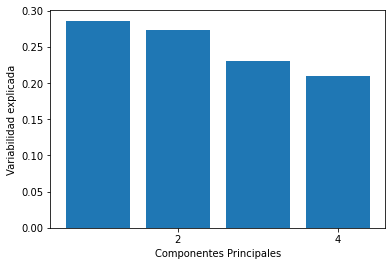

In [80]:
list_x = list(range(1, len(variabilidad_explicada)+1))

# Grafico varianza explicada y cantidad de componentes principales

plt.locator_params('x', nbins = 4)
plt.bar(list_x, variabilidad_explicada)
plt.xlabel(r'Componentes Principales')
plt.ylabel('Variabilidad explicada')
plt.show()

Vemos como los cuatro componentes tienen una canidad significativa de variablididad explicada. Por lo tanto aplicarle PCA al dataset resultaría en una perdida de información elevada. De esta forma concluimos que no es beneficioso realizar PCA


#### Persistencia archivos


In [81]:
#Guardamos el dataset reducido
train, test = train_test_split(ds_prop_reducido,
                                                    test_size=0.2,    #20% al conjunto de test
                                                    random_state=0)
print('# Datos Entrenamiento: {}'.format(len(train)))
print('# Datos Prueba: {}'.format(len(test)))

train.to_csv("properati_argentina_reducido_train.csv")
test.to_csv("properati_argentina_reducido_test.csv")

# Datos Entrenamiento: 55716
# Datos Prueba: 13929


In [82]:
ds_prop_reducido

latitud   longitud property_type  property_rooms  \
161952 -34.540279 -58.464803  Departamento             3.0   
308773 -34.606780 -58.391341  Departamento             2.0   
367023 -34.569511 -58.456376  Departamento             4.0   
180464 -34.587250 -58.446779  Departamento             2.0   
362258 -34.606312 -58.493226            PH             3.0   
...           ...        ...           ...             ...   
108573 -34.654809 -58.404746  Departamento             3.0   
238236 -34.581673 -58.443382  Departamento             1.0   
221078 -34.597355 -58.395413  Departamento             3.0   
226504 -34.607323 -58.512419  Departamento             3.0   
357098 -34.620165 -58.424036            PH             2.0   

        property_surface_total  property_price  
161952                    61.0        130000.0  
308773                    73.0        120000.0  
367023                   157.0        400000.0  
180464                    36.0         93000.0  
362258                    45.0         75000.0  
...                        ...             ...  
108573                    59.0         55000.0  
238236                    40.0        110000.0  
221078                   101.0        207000.0  
226504                    65.0        120000.0  
357098                    57.0         75000.0  

[69645 rows x 6 columns]

# Agrupamiento


## Clustering


In [83]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans

Sacamos columnas que no se utilizan


In [84]:
ds_kmeans = ds_atipicos_copia.copy()
columnas = ["start_date", "end_date", "created_on", "place_l2", "place_l3", "operation", "property_currency", "property_title", "latitud", "longitud"]
ds_kmeans.drop(columns = columnas, inplace = True)

Aplicamos dummies para property_type


In [85]:
ds_kmeans = pd.get_dummies(ds_kmeans, columns=['property_type'])
ds_kmeans

property_rooms  property_bedrooms  property_surface_total  \
161952             3.0                2.0                    61.0   
308773             2.0                1.0                    73.0   
367023             4.0                3.0                   157.0   
180464             2.0                1.0                    36.0   
362258             3.0                2.0                    45.0   
...                ...                ...                     ...   
108573             3.0                2.0                    59.0   
238236             1.0                1.0                    40.0   
221078             3.0                2.0                   101.0   
226504             3.0                2.0                    65.0   
357098             2.0                1.0                    57.0   

        property_surface_covered  property_price  property_type_Casa  \
161952                      56.0        130000.0                   0   
308773                      62.0        120000.0                   0   
367023                     135.0        400000.0                   0   
180464                      36.0         93000.0                   0   
362258                      45.0         75000.0                   0   
...                          ...             ...                 ...   
108573                      59.0         55000.0                   0   
238236                      35.0        110000.0                   0   
221078                      91.0        207000.0                   0   
226504                      57.0        120000.0                   0   
357098                      51.0         75000.0                   0   

        property_type_Departamento  property_type_PH  
161952                           1                 0  
308773                           1                 0  
367023                           1                 0  
180464                           1                 0  
362258                           0                 1  
...                            ...               ...  
108573                           1                 0  
238236                           1                 0  
221078                           1                 0  
226504                           1                 0  
357098                           0                 1  

[69645 rows x 8 columns]

Aplicamos MinMaxScaler para variables numericas


In [86]:
scaler = MinMaxScaler()
ds_kmeans["property_surface_total"] = scaler.fit_transform(ds_kmeans["property_surface_total"].to_frame())
ds_kmeans["property_surface_covered"] = scaler.fit_transform(ds_kmeans["property_surface_covered"].to_frame())
ds_kmeans["property_price"] = scaler.fit_transform(ds_kmeans["property_price"].to_frame())
ds_kmeans["property_bedrooms"] = scaler.fit_transform(ds_kmeans["property_bedrooms"].to_frame())
ds_kmeans["property_rooms"] = scaler.fit_transform(ds_kmeans["property_rooms"].to_frame())
ds_kmeans

property_rooms  property_bedrooms  property_surface_total  \
161952        0.051282           0.032258                0.000307   
308773        0.025641           0.000000                0.000380   
367023        0.076923           0.064516                0.000886   
180464        0.025641           0.000000                0.000157   
362258        0.051282           0.032258                0.000211   
...                ...                ...                     ...   
108573        0.051282           0.032258                0.000295   
238236        0.000000           0.000000                0.000181   
221078        0.051282           0.032258                0.000548   
226504        0.051282           0.032258                0.000331   
357098        0.025641           0.000000                0.000283   

        property_surface_covered  property_price  property_type_Casa  \
161952                  0.000258        0.010421                   0   
308773                  0.000286        0.009587                   0   
367023                  0.000622        0.032930                   0   
180464                  0.000166        0.007336                   0   
362258                  0.000207        0.005836                   0   
...                          ...             ...                 ...   
108573                  0.000272        0.004168                   0   
238236                  0.000161        0.008754                   0   
221078                  0.000419        0.016840                   0   
226504                  0.000263        0.009587                   0   
357098                  0.000235        0.005836                   0   

        property_type_Departamento  property_type_PH  
161952                           1                 0  
308773                           1                 0  
367023                           1                 0  
180464                           1                 0  
362258                           0                 1  
...                            ...               ...  
108573                           1                 0  
238236                           1                 0  
221078                           1                 0  
226504                           1                 0  
357098                           0                 1  

[69645 rows x 8 columns]

### Estimamos la cantidad apropiada de grupos que se deben formar.


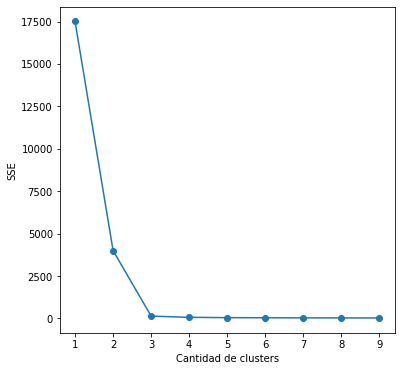

In [87]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(ds_kmeans)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

En este caso son 3


Aplicamos k-means con la cantidad de clusters indicados por la regla del codo


In [88]:
kmeans = KMeans(3, random_state=123)
kmeans.fit(ds_kmeans)

KMeans(n_clusters=3, random_state=123)

In [89]:
clusters = kmeans.predict(ds_kmeans)
ds_kmeans["cluster"] = clusters

### Silhouette


/home/fanu/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


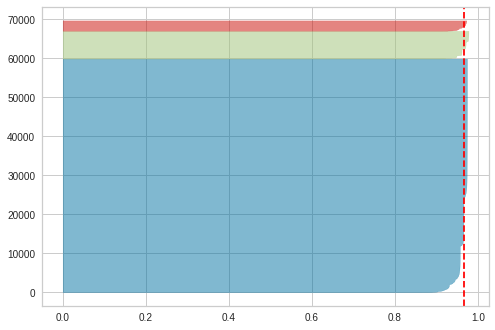

In [90]:
from yellowbrick.cluster import SilhouetteVisualizer

# Visualizamos el gráfico de silueta
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')    # Instancio el visualizador
visualizer.fit(ds_kmeans.drop(columns=["cluster"]))
plt.show()

Como se observa en el grafico, tenemos 3 grupos sin mediciones que esten mas cerca de otro cluster que del que pertenecen.


### Analisis por grupo


In [91]:
ds_kmeans.shape

(69645, 9)

Como se puede observar, los grupos fueron creados en funcion de la caracteristica de property_type.
El cluster 0 es propiedad del tipo Departamento, el cluster 1 propiedad del tipo PH y el cluster 2 porpiedad de tipo casa


In [92]:
ds_kmeans["property_type"] = ds_atipicos_copia["property_type"]
pd.crosstab(ds_kmeans['cluster'],ds_kmeans['property_type'])

property_type  Casa  Departamento    PH
cluster                                
0                 0         59868     0
1                 0             0  7135
2              2642             0     0

### Mapa


Delimitacionn de capital federal


In [93]:
ds_mapa_point = geopandas.GeoDataFrame(ds_atipicos_copia, geometry=geopandas.points_from_xy(ds_atipicos_copia.longitud, ds_atipicos_copia.latitud))
ds_mapa_capital = geopandas.read_file("barrios_2/barrios-polygon.shp")

In [94]:
ds_mapa_point["cluster"] = ds_kmeans["cluster"]

fig, ax = plt.subplots()
x=ds_clasificacion["latitud"]
y=ds_clasificacion["longitud"]
ds_clasificacion.loc[ds_clasificacion['precioxm2_q'] == "bajo",'color'] = 1
ds_clasificacion.loc[ds_clasificacion['precioxm2_q'] == "medio",'color'] = 2
ds_clasificacion.loc[ds_clasificacion['precioxm2_q'] == "alto",'color'] = 3

scatter = ax.scatter(x, y, c=ds_clasificacion['color'])
legend1 = ax.legend(\*scatter.legend_elements(),
title="Classes")
ax.add_artist(legend1)
plt.show()


Text(0.5, 1.0, 'Mapa de propiedades en CABA')

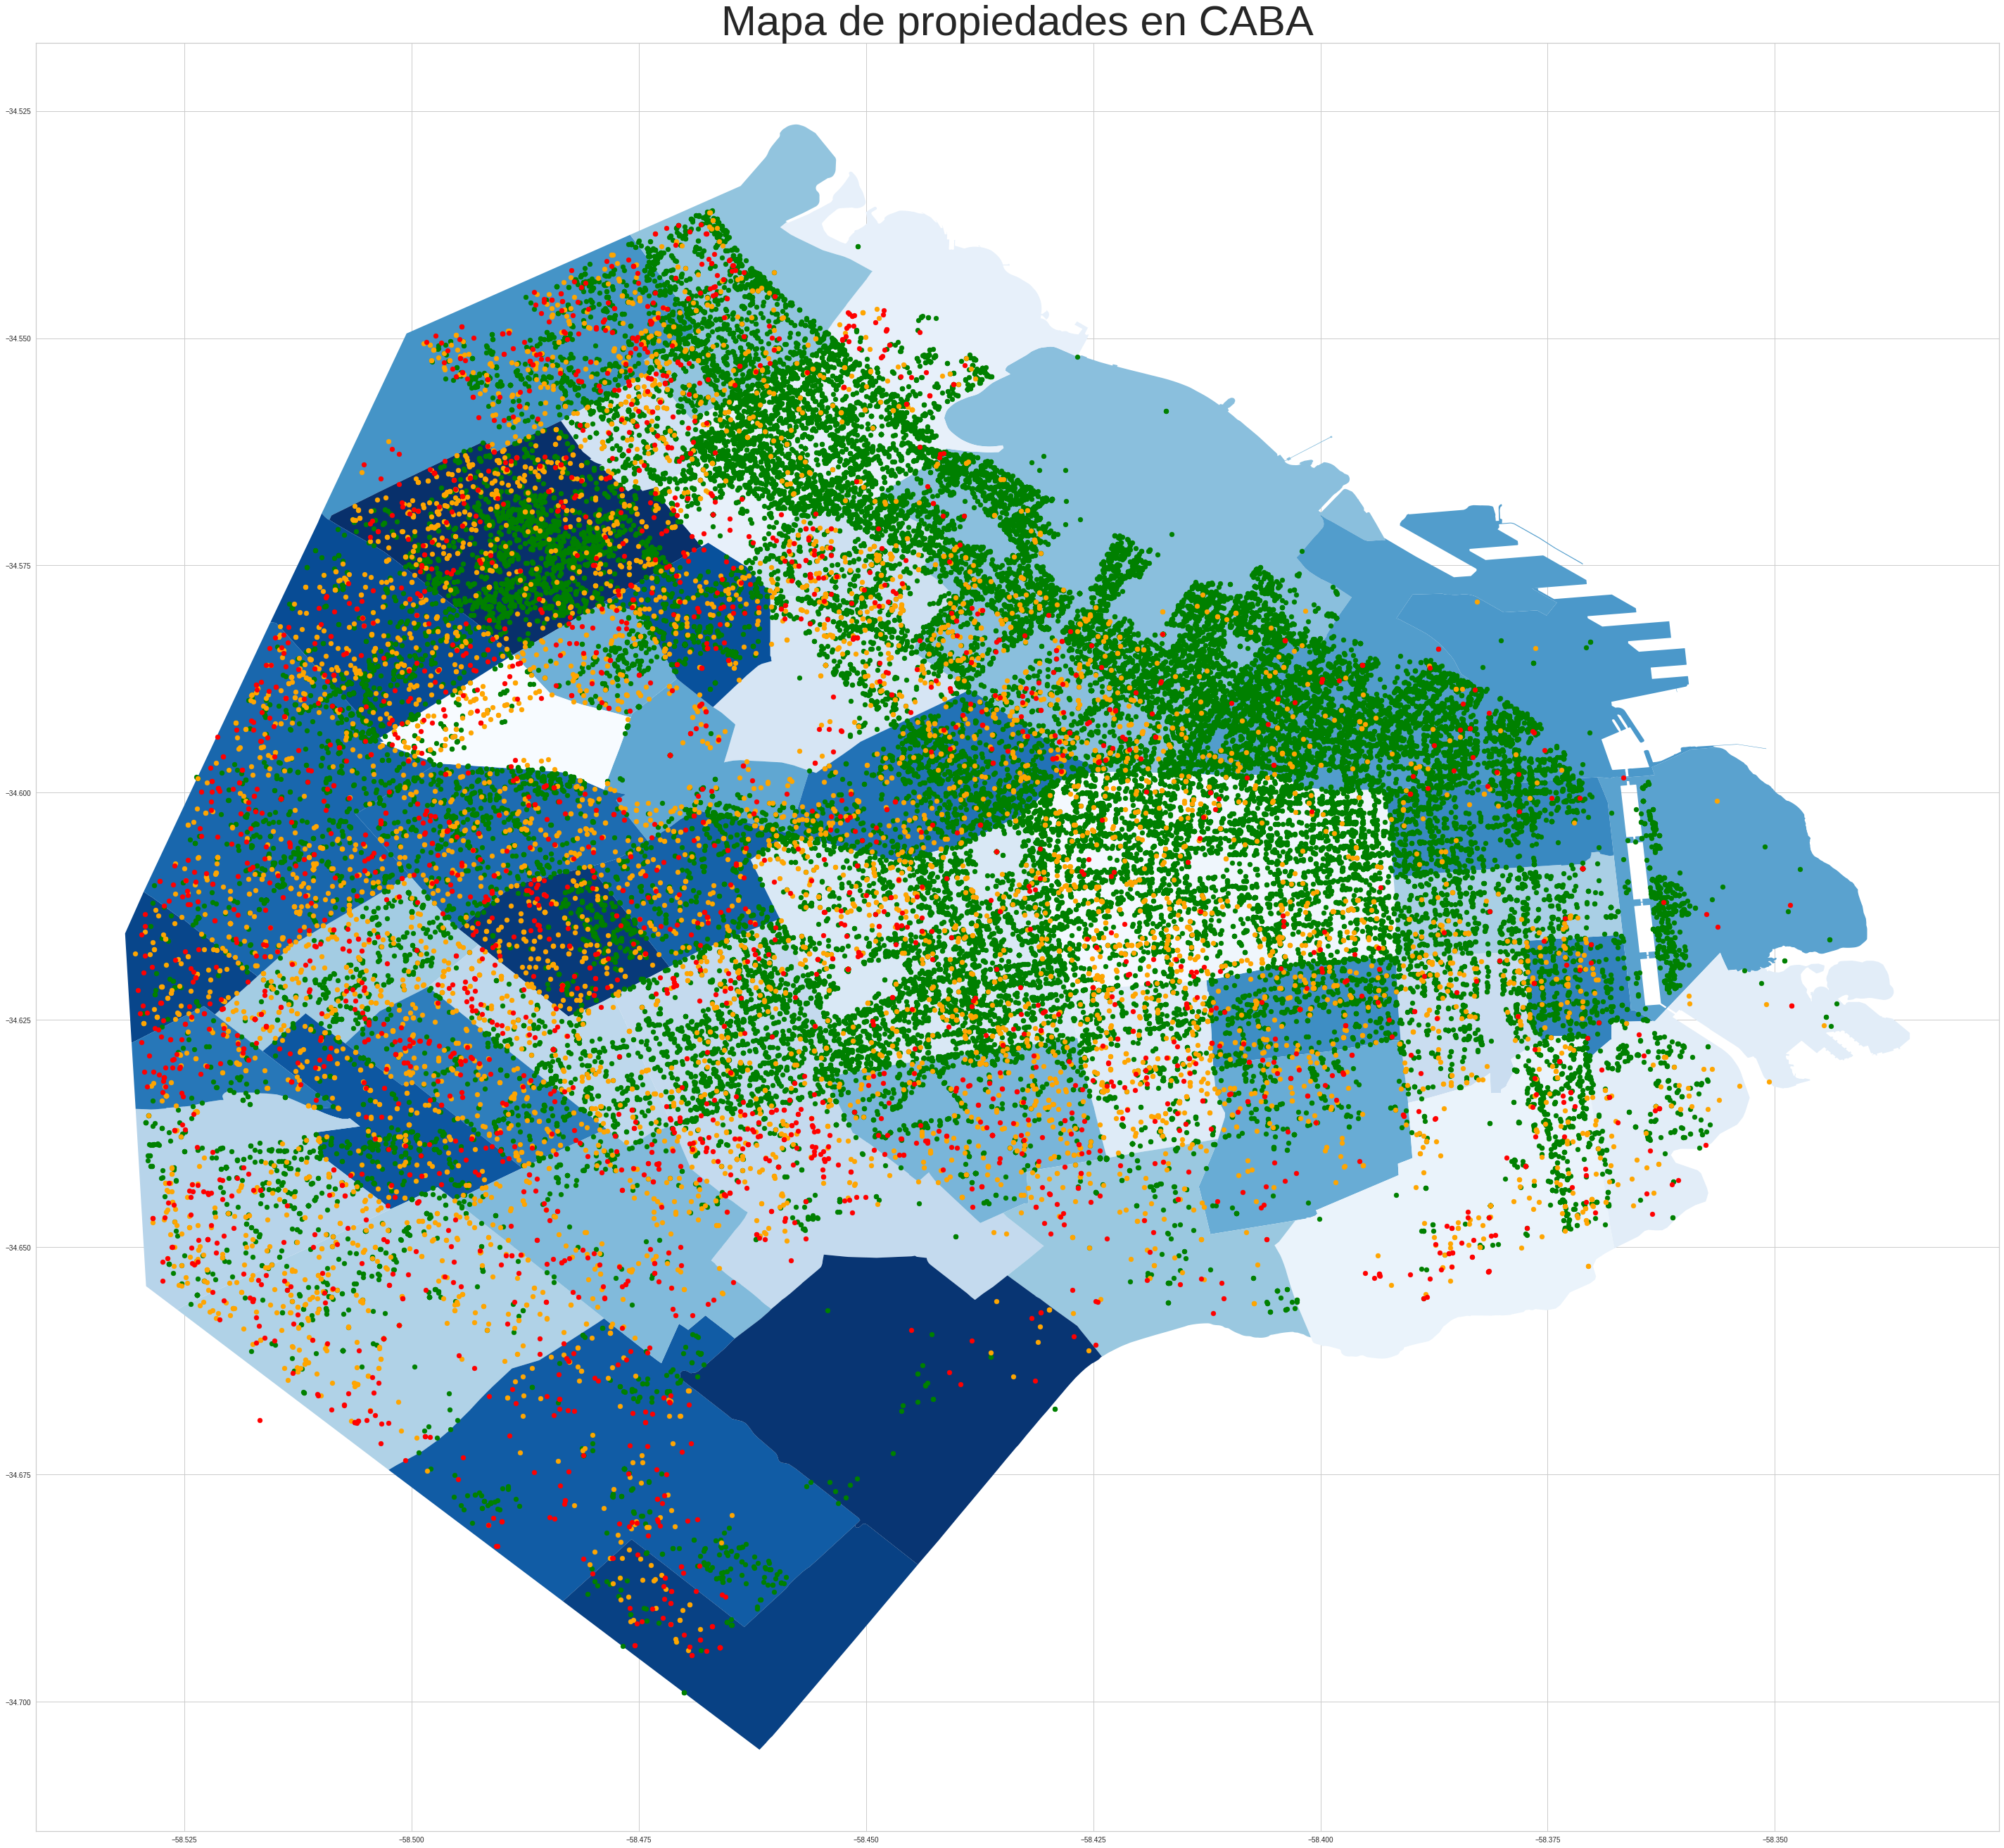

In [95]:
fig,ax = plt.subplots(figsize = (50,50))
ds_mapa_capital.plot(ax = ax, column = "BARRIO", cmap = "Blues")
ds_mapa_point[ds_mapa_point["cluster"] == 0].plot(ax = ax, color = "green") # departamentos
ds_mapa_point[ds_mapa_point["cluster"] == 1].plot(ax = ax, color = "orange") #ph
ds_mapa_point[ds_mapa_point["cluster"] == 2].plot(ax = ax, color = "red") # casa
ax.set_title("Mapa de propiedades en CABA", fontdict = {"fontsize" : "60"})